# Cluster EDA

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# docker 환경에 대한 코드라 무시해도 됩니다.

# # Warning 무시
# warnings.filterwarnings('ignore', category=UserWarning)

# # Seaborn 테마 설정
# sns.set_theme(style='whitegrid')

# # matplotlib 한글 폰트 설정
# os.system('rm -rf ~/.cache/matplotlib')
# os.system('fc-cache -fv')

# plt.rc('font', family='NanumBarunGothic')
# plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 설치된 폰트 확인
fonts = [f.name for f in fm.fontManager.ttflist]
korean_fonts = [f for f in fonts if any(korean in f for korean in ['Nanum', 'Malgun', '맑은', '고딕', 'Gothic'])]
print("사용 가능한 한글 폰트:")
for font in korean_fonts:
    print(f"- {font}")

# 폰트 설정 (시스템에 설치된 한글 폰트 중 하나 선택)
# 아래 중 시스템에 설치된 폰트로 변경하세요
if 'NanumBarunGothic' in fonts:
    font_family = 'NanumBarunGothic'
elif 'NanumGothic' in fonts:
    font_family = 'NanumGothic'
elif 'Malgun Gothic' in fonts:
    font_family = 'Malgun Gothic'  # Windows 기본 한글 폰트
else:
    # 설치된 한글 폰트가 없는 경우
    if len(korean_fonts) > 0:
        font_family = korean_fonts[0]
    else:
        font_family = plt.rcParams['font.family']
        print("한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")

# 폰트 설정 적용
plt.rc('font', family=font_family)
plt.rcParams['axes.unicode_minus'] = False

print(f"선택된 폰트: {font_family}")

사용 가능한 한글 폰트:
- Yu Gothic
- Malgun Gothic
- Yu Gothic
- BIZ UDGothic
- BIZ UDGothic
- MS Gothic
- Yu Gothic
- Malgun Gothic
- Yu Gothic
- Malgun Gothic
- Franklin Gothic Medium
- Franklin Gothic Medium
선택된 폰트: Malgun Gothic


In [4]:
# 데이터 로드
data_df = pd.read_csv('../data/total_cluster.csv', index_col = 0)
cluster_df = pd.read_csv('../data/Size_ordered_clusters.csv', index_col = 0)

# 전체 전처리 데이터 + 클러스터 데이터
df = pd.merge(data_df, cluster_df, left_on='상권', right_on = '상권')
df_final = df.drop(columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'Cluster'])

In [5]:
data_column = df_final.columns.tolist()

mask_cluster = [col for col in data_column if 'cluster' in str(col)]

def help_me_median(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 중위값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 중위값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 중위값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 중위값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].median().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'median_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='median_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()

  # 시각화 함수 - 연도별 클러스터 중위값 트렌드

  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    # for cluster in sorted(result_df['cluster'].unique()):
    for cluster in sorted([c for c in result_df['cluster'].unique() if c != 0]):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['median_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 중위값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 중위값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  plt.show()
  return pivot_df

def help_me_mean(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 평균균값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 평균균값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 평균균값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 평균균값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].mean().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'mean_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='mean_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()
  
  # 시각화 함수 - 연도별 클러스터 중위값 트렌드
  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    # for cluster in sorted(result_df['cluster'].unique()):
    for cluster in sorted([c for c in result_df['cluster'].unique() if c != 0]):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['mean_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 평균값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 평균값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  plt.show()
  return pivot_df

# Case 1
1. 평일의 유동인구수는 1번이 높다(젠트리피케이션이라면)
2. 주말의 유동인구수는 2번이 높다. -> 따라서 젠트리피케이션의 주말에도 놀만한 거리를 만들면 젠트리피케이션을 방지할수있다.

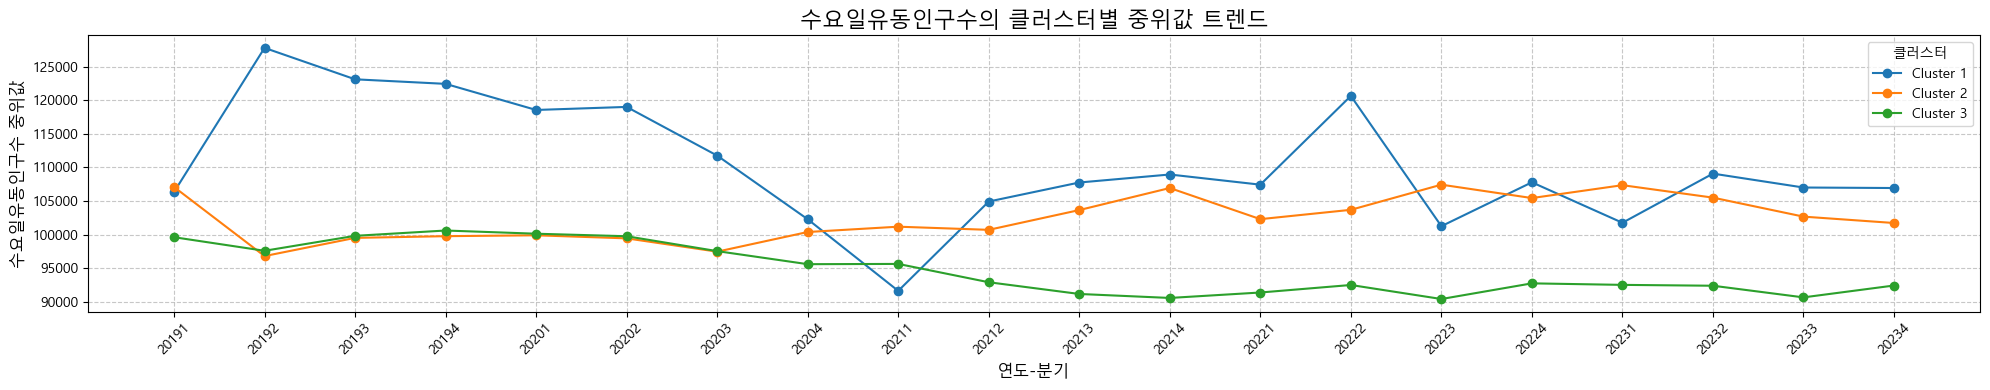

cluster  year quarter period        0         1         2         3
0        2019       1  20191  40509.0  106345.0  107091.5   99603.0
1        2019       2  20192  37181.0  127831.0   96790.5   97579.0
2        2019       3  20193  35857.0  123147.0   99503.0   99808.0
3        2019       4  20194  38610.0  122467.0   99757.0  100601.0
4        2020       1  20201  40027.0  118575.5   99890.0  100124.0
5        2020       2  20202  38552.0  119030.5   99432.0   99748.0
6        2020       3  20203  38312.0  111770.0   97448.0   97528.0
7        2020       4  20204  33432.0  102282.0  100378.5   95583.0
8        2021       1  20211  32455.0   91602.5  101172.0   95620.0
9        2021       2  20212  33475.0  104922.0  100702.5   92889.0
10       2021       3  20213  33964.0  107760.0  103651.0   91141.0
11       2021       4  20214  32313.0  108953.0  106938.0   90546.5
12       2022       1  20221  31336.0  107437.0  102296.0   91359.0
13       2022       2  20222  30846.0  120665.0  103687.0   92478.5
14       2022       3  20223  86348.0  101247.5  107436.0   90388.0
15       2022       4  20224  86134.0  107789.0  105441.0   92723.0
16       2023       1  20231  87585.0  101755.0  107361.0   92496.5
17       2023       2  20232  85508.0  109084.5  105504.0   92368.0
18       2023       3  20233  82240.0  107013.0  102672.0   90632.0
19       2023       4  20234  60811.5  106937.0  101721.5   92401.0

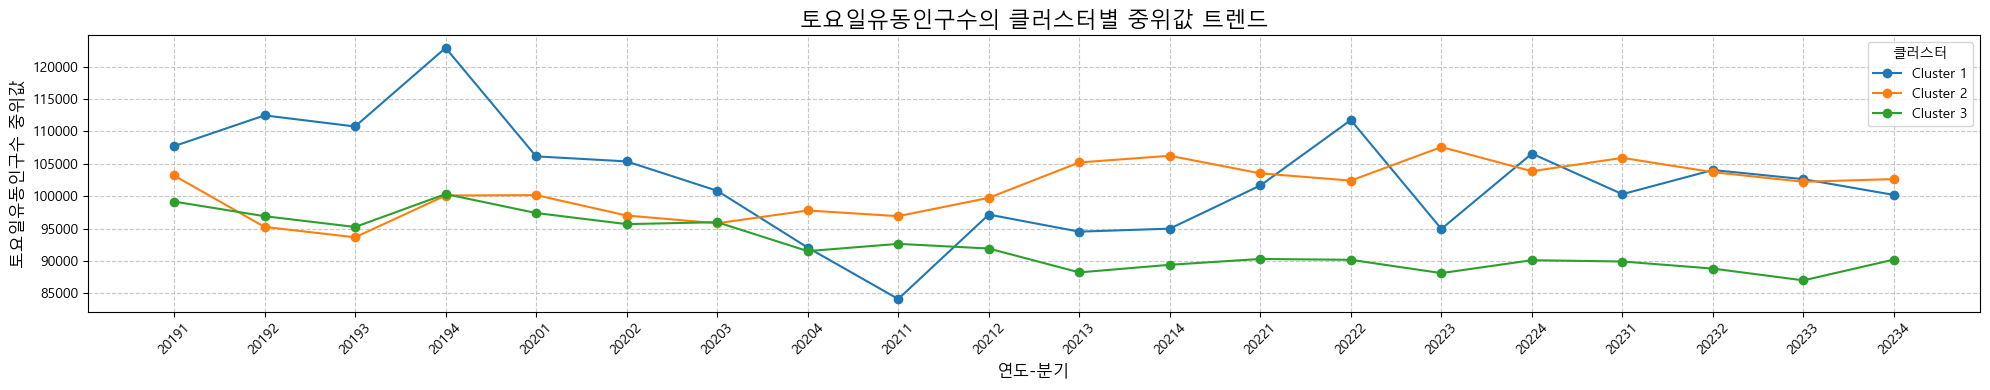

cluster  year quarter period        0         1         2         3
0        2019       1  20191  41998.0  107733.0  103212.5   99179.5
1        2019       2  20192  37552.0  112488.5   95267.5   96923.0
2        2019       3  20193  36606.0  110772.0   93661.0   95254.0
3        2019       4  20194  38699.0  122911.0  100111.0  100335.0
4        2020       1  20201  39883.0  106160.0  100176.0   97411.0
5        2020       2  20202  37896.0  105382.5   97026.0   95695.5
6        2020       3  20203  37344.0  100848.0   95827.5   95993.5
7        2020       4  20204  35343.0   92073.0   97802.0   91528.0
8        2021       1  20211  35184.0   84131.0   96926.0   92649.0
9        2021       2  20212  36198.0   97172.0   99753.0   91928.0
10       2021       3  20213  33046.0   94532.0  105221.0   88242.0
11       2021       4  20214  31893.0   94998.0  106250.0   89415.5
12       2022       1  20221  31423.0  101662.0  103537.0   90318.0
13       2022       2  20222  30737.0  111765.0  102415.5   90183.5
14       2022       3  20223  83859.0   94958.0  107599.0   88131.0
15       2022       4  20224  85645.0  106583.0  103865.0   90125.0
16       2023       1  20231  85219.0  100321.0  105927.5   89923.5
17       2023       2  20232  84911.0  104054.5  103720.0   88828.0
18       2023       3  20233  77006.0  102638.0  102232.0   87009.0
19       2023       4  20234  60055.5  100203.0  102654.5   90224.5

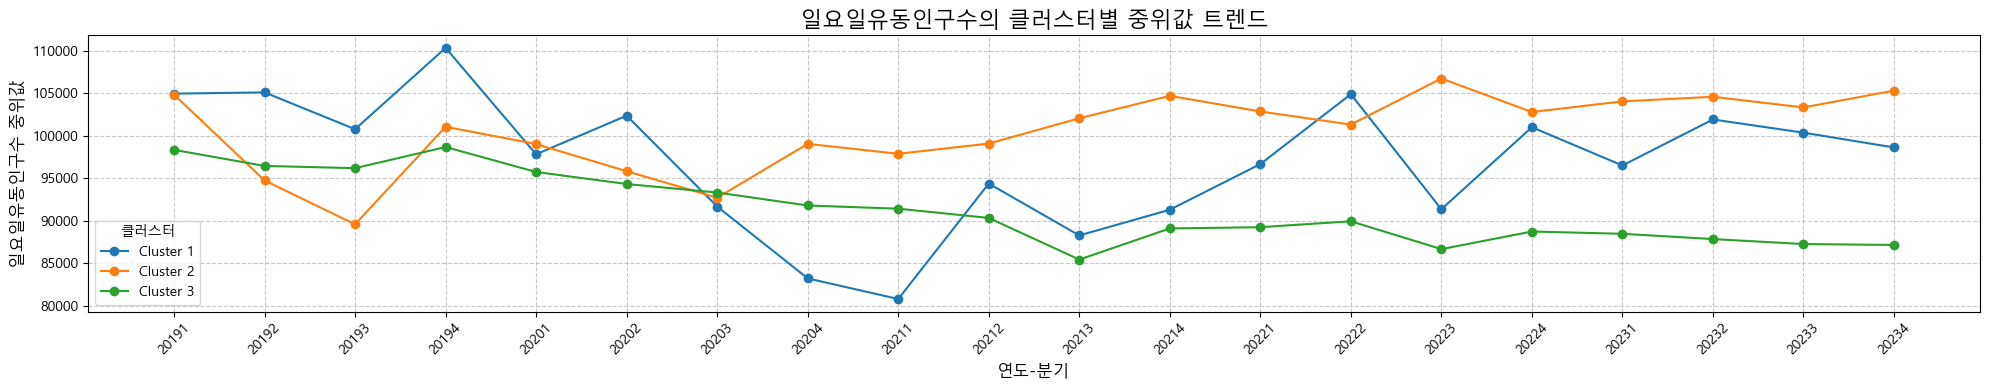

cluster  year quarter period        0         1         2        3
0        2019       1  20191  40302.0  104927.0  104807.0  98310.5
1        2019       2  20192  36385.0  105073.0   94711.0  96422.0
2        2019       3  20193  35205.0  100739.0   89551.0  96158.0
3        2019       4  20194  37355.0  110308.0  101030.0  98645.0
4        2020       1  20201  38243.0   97788.5   98991.5  95708.0
5        2020       2  20202  36891.0  102337.0   95799.0  94293.5
6        2020       3  20203  36375.0   91646.0   92678.0  93290.5
7        2020       4  20204  35096.0   83189.0   99016.0  91766.0
8        2021       1  20211  34900.0   80763.5   97851.5  91390.0
9        2021       2  20212  35437.0   94345.5   99049.5  90303.0
10       2021       3  20213  32566.0   88242.5  102027.5  85405.0
11       2021       4  20214  30749.0   91265.0  104666.0  89065.0
12       2022       1  20221  30422.0   96638.0  102827.0  89213.0
13       2022       2  20222  30350.0  104859.0  101285.5  89908.5
14       2022       3  20223  82280.0   91327.5  106705.0  86635.0
15       2022       4  20224  86843.0  100973.0  102762.0  88704.0
16       2023       1  20231  86496.0   96473.0  104014.0  88436.5
17       2023       2  20232  85232.0  101886.0  104556.5  87816.0
18       2023       3  20233  72536.0  100333.0  103301.0  87231.0
19       2023       4  20234  59424.5   98595.0  105284.5  87123.5

In [6]:
display(help_me_median(df_final, '수요일유동인구수'))
display(help_me_median(df_final, '토요일유동인구수'))
display(help_me_median(df_final, '일요일유동인구수'))

# Case 2
1. 1번 군집이 2번군집에 비해 압도적으로 임대료가 높음
2. 임대료가 감소되는 정책이나 그런게 있으면 좋ㅇ륻ㅅ

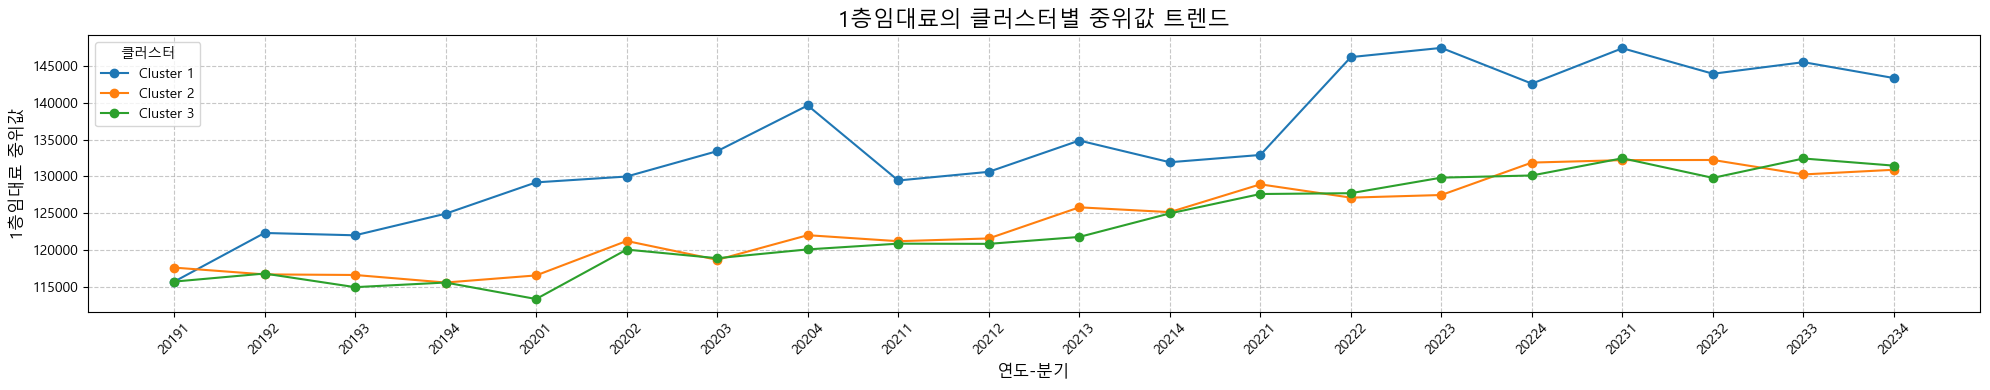

cluster  year quarter period         0         1         2         3
0        2019       1  20191  123624.0  115740.0  117653.0  115755.0
1        2019       2  20192  124656.0  122342.5  116732.0  116847.0
2        2019       3  20193  117668.0  122027.0  116653.0  115004.0
3        2019       4  20194  114818.0  124952.0  115630.0  115630.0
4        2020       1  20201  114196.0  129195.5  116594.0  113398.0
5        2020       2  20202  121953.0  129986.5  121258.0  120093.0
6        2020       3  20203  117856.0  133423.0  118703.0  118926.0
7        2020       4  20204  121261.0  139612.0  122042.0  120118.0
8        2021       1  20211  114577.0  129450.5  121228.0  120895.0
9        2021       2  20212  111176.0  130622.5  121601.0  120868.0
10       2021       3  20213  111580.0  134860.5  125815.0  121804.0
11       2021       4  20214  121147.0  131923.0  125165.0  124991.0
12       2022       1  20221  138085.0  132907.0  128929.0  127619.0
13       2022       2  20222  129653.0  146160.0  127128.5  127728.5
14       2022       3  20223  140345.0  147408.5  127484.5  129837.0
15       2022       4  20224  141707.0  142567.0  131876.0  130130.0
16       2023       1  20231  158908.0  147362.0  132206.0  132460.0
17       2023       2  20232  156111.0  143906.5  132228.0  129803.0
18       2023       3  20233  149740.0  145475.0  130270.0  132429.0
19       2023       4  20234  140427.0  143321.0  130903.0  131460.5

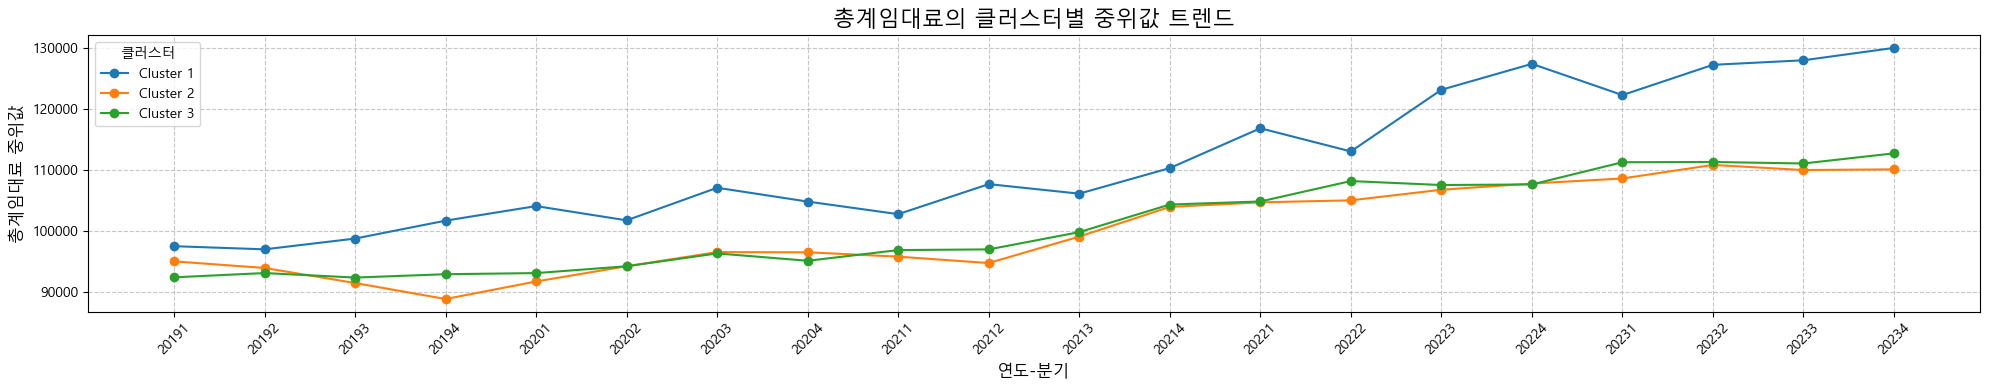

cluster  year quarter period         0         1         2         3
0        2019       1  20191   86823.0   97518.0   95026.5   92403.5
1        2019       2  20192   94573.0   97001.0   93941.5   93106.0
2        2019       3  20193   99931.0   98770.0   91471.0   92364.0
3        2019       4  20194  103167.0  101711.0   88842.0   92916.0
4        2020       1  20201  103002.0  104103.0   91724.5   93100.0
5        2020       2  20202  105958.0  101761.5   94224.0   94224.0
6        2020       3  20203  106767.0  107116.0   96547.0   96332.0
7        2020       4  20204  106596.0  104844.0   96517.0   95124.0
8        2021       1  20211  102665.0  102778.0   95799.5   96876.0
9        2021       2  20212  106894.0  107709.0   94749.5   96993.0
10       2021       3  20213  110913.0  106146.5   99093.5   99827.0
11       2021       4  20214  119635.0  110345.0  103967.5  104359.0
12       2022       1  20221  122920.0  116885.0  104719.0  104862.0
13       2022       2  20222  128684.0  113081.0  105047.5  108216.0
14       2022       3  20223  129044.0  123208.0  106789.0  107562.0
15       2022       4  20224  125431.0  127464.0  107808.0  107659.0
16       2023       1  20231  129588.0  122336.0  108641.0  111305.0
17       2023       2  20232  127258.0  127307.0  110865.0  111346.0
18       2023       3  20233  121059.0  128051.0  110024.0  111102.0
19       2023       4  20234  112717.5  130086.5  110136.5  112767.5

In [7]:
display(help_me_median(df_final, '1층임대료'))
display(help_me_median(df_final, '총계임대료'))

# Case 3 : 직장인구
- 0번에 대한 삭제 근거 찾기

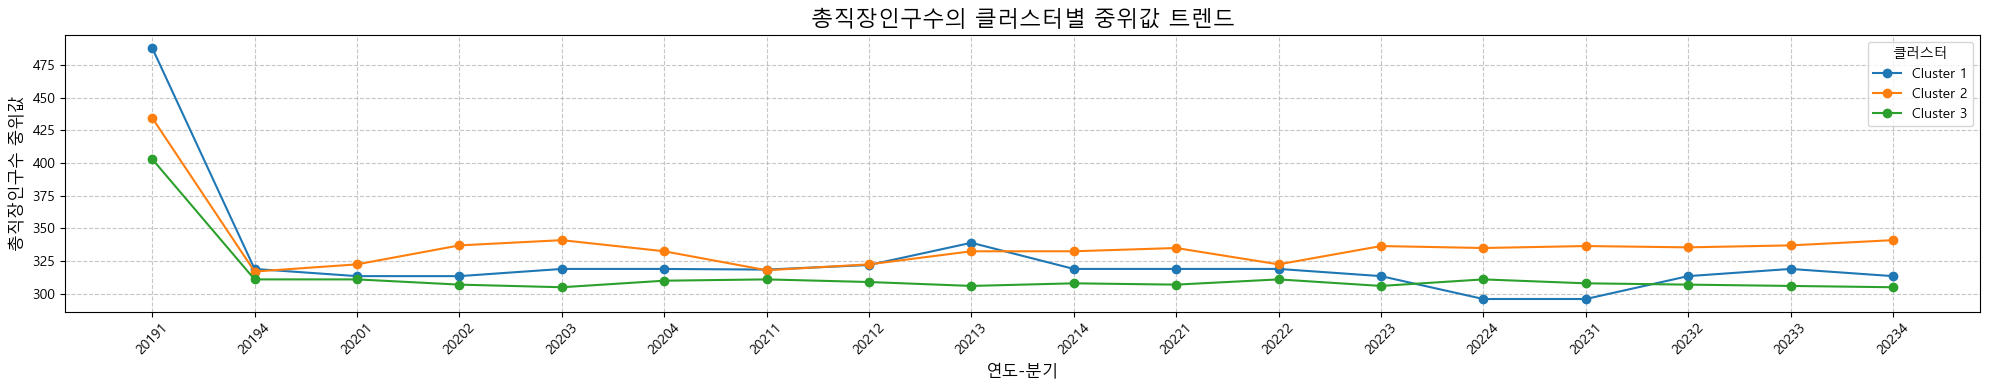

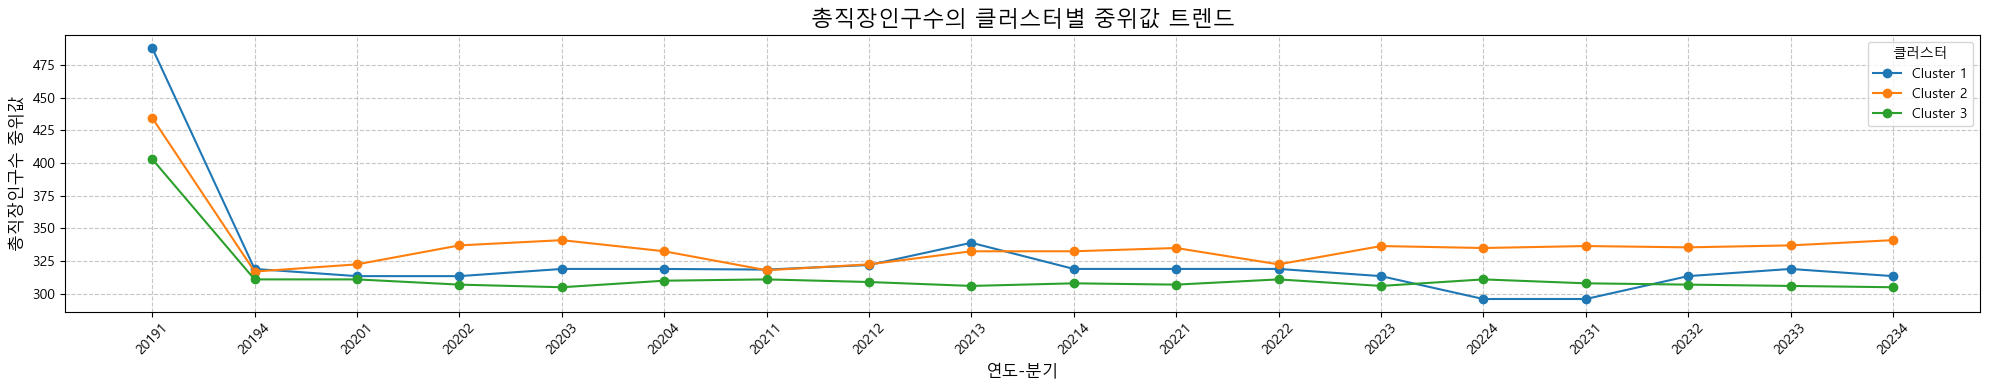

cluster  year quarter period      0      1      2      3
0        2019       1  20191  270.0  488.0  434.5  403.0
1        2019       4  20194  275.0  319.0  317.0  311.0
2        2020       1  20201  275.0  313.5  322.5  311.0
3        2020       2  20202  275.0  313.5  337.0  307.0
4        2020       3  20203  275.0  319.0  341.0  305.0
5        2020       4  20204  143.0  319.0  332.5  310.0
6        2021       1  20211  143.0  318.5  318.0  311.0
7        2021       2  20212  275.0  322.0  322.5  309.0
8        2021       3  20213  275.0  339.0  332.5  306.0
9        2021       4  20214  275.0  319.0  332.5  308.0
10       2022       1  20221  275.0  319.0  335.0  307.0
11       2022       2  20222  275.0  319.0  322.5  311.0
12       2022       3  20223  593.0  313.5  336.5  306.0
13       2022       4  20224  593.0  296.0  335.0  311.0
14       2023       1  20231  593.0  296.0  336.5  308.0
15       2023       2  20232  593.0  313.5  335.5  307.0
16       2023       3  20233  593.0  319.0  337.0  306.0
17       2023       4  20234  434.0  313.5  341.0  305.0

In [8]:
help_me_median(df_final, '총직장인구수')
help_me_median(df_final, '총직장인구수')

# Case 4 : 점포수

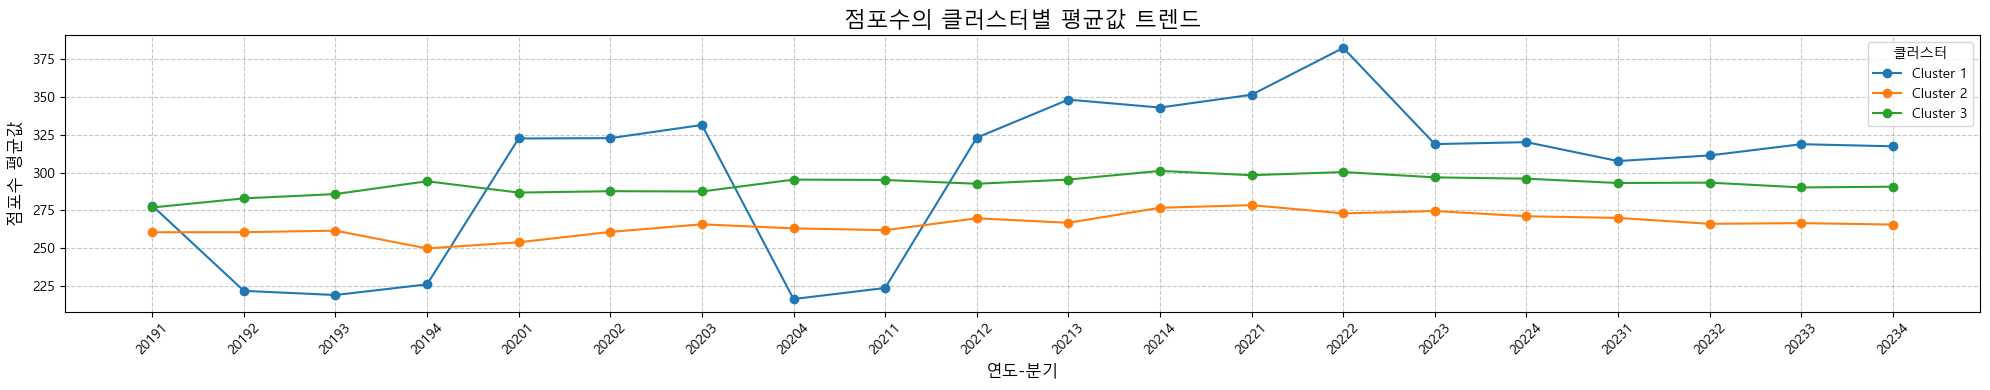

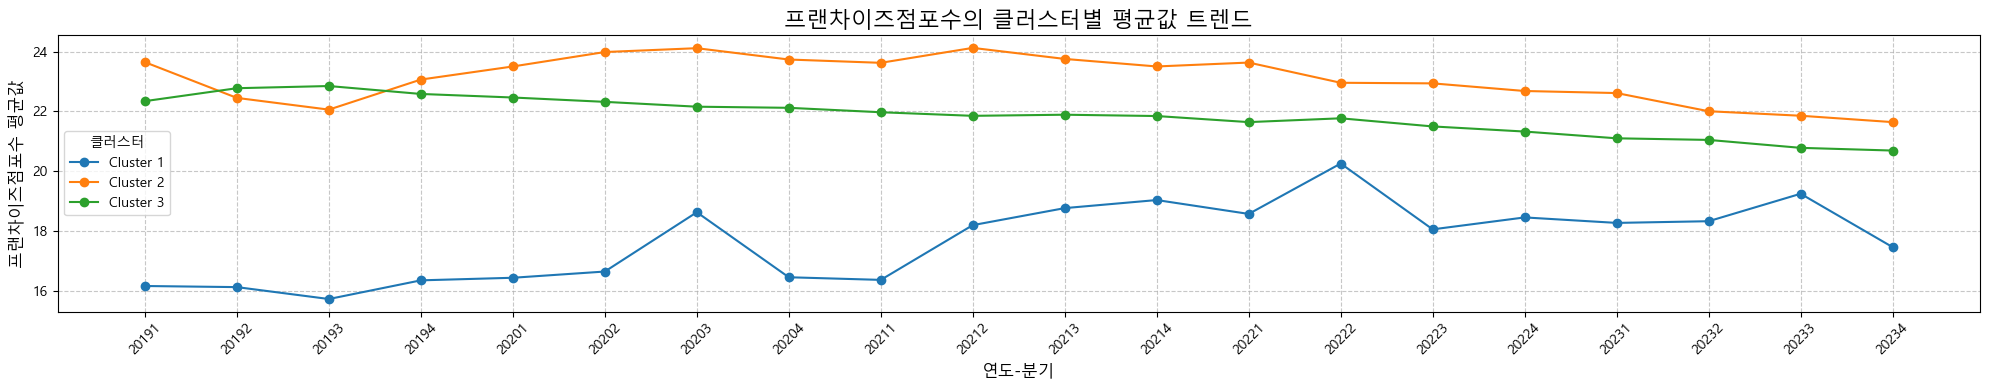

cluster  year quarter period          0          1          2          3
0        2019       1  20191   9.400000  16.162162  23.643333  22.341019
1        2019       2  20192   9.600000  16.125000  22.449324  22.773109
2        2019       3  20193   9.400000  15.727273  22.057239  22.845969
3        2019       4  20194   9.400000  16.351351  23.062295  22.581197
4        2020       1  20201   9.600000  16.437500  23.500000  22.462275
5        2020       2  20202   9.600000  16.645833  23.982206  22.317308
6        2020       3  20203   9.000000  18.627451  24.110714  22.155422
7        2020       4  20204   7.666667  16.454545  23.732026  22.117718
8        2021       1  20211   7.666667  16.366667  23.621711  21.969843
9        2021       2  20212   8.800000  18.196429  24.120805  21.850062
10       2021       3  20213   9.000000  18.765625  23.751724  21.887237
11       2021       4  20214   9.400000  19.035088  23.500000  21.843210
12       2022       1  20221   9.000000  18.571429  23.630508  21.640147
13       2022       2  20222   9.000000  20.255814  22.954839  21.767327
14       2022       3  20223  17.714286  18.055556  22.934932  21.495695
15       2022       4  20224  17.285714  18.454545  22.680000  21.324487
16       2023       1  20231  16.571429  18.271186  22.611111  21.098795
17       2023       2  20232  15.857143  18.327586  22.003597  21.044957
18       2023       3  20233  15.714286  19.245614  21.853047  20.780073
19       2023       4  20234  16.500000  17.461538  21.640000  20.689356

In [9]:
help_me_mean(df_final, '점포수')
help_me_mean(df_final, '프랜차이즈점포수')

# Case 5 : 연령별 전체적으로 확인

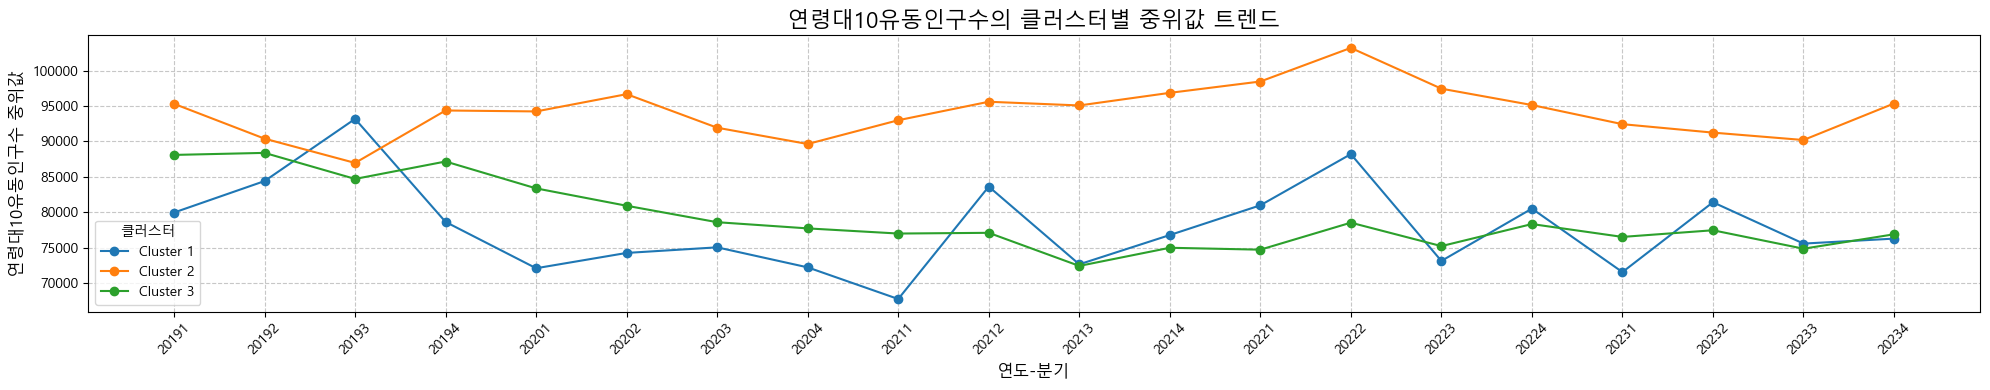

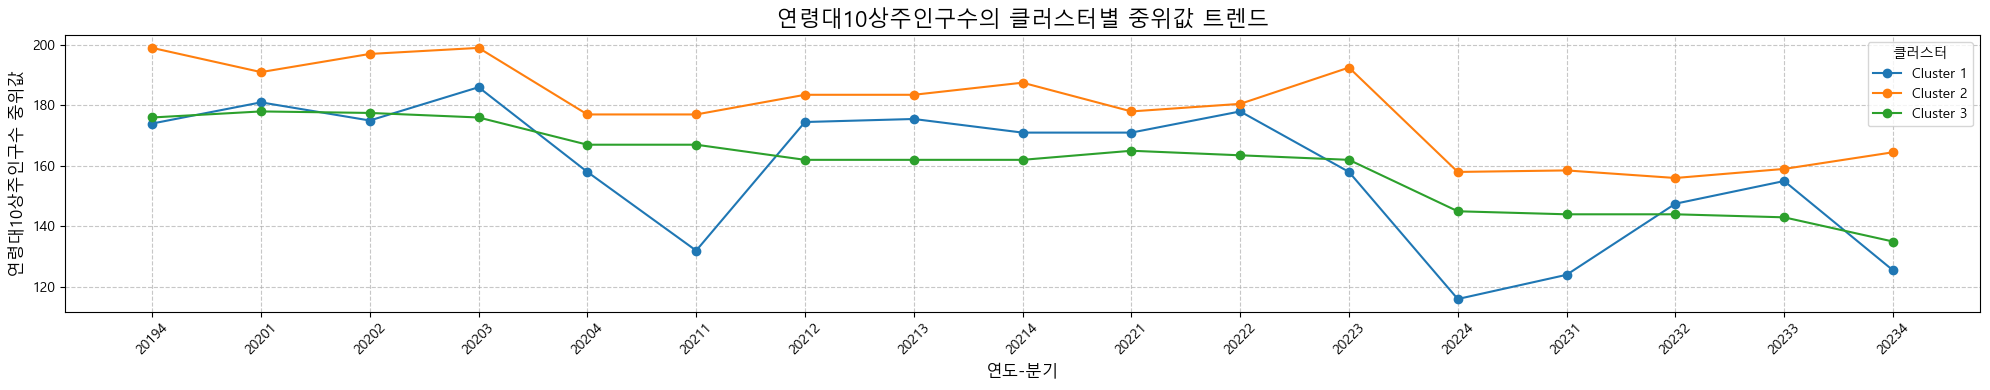

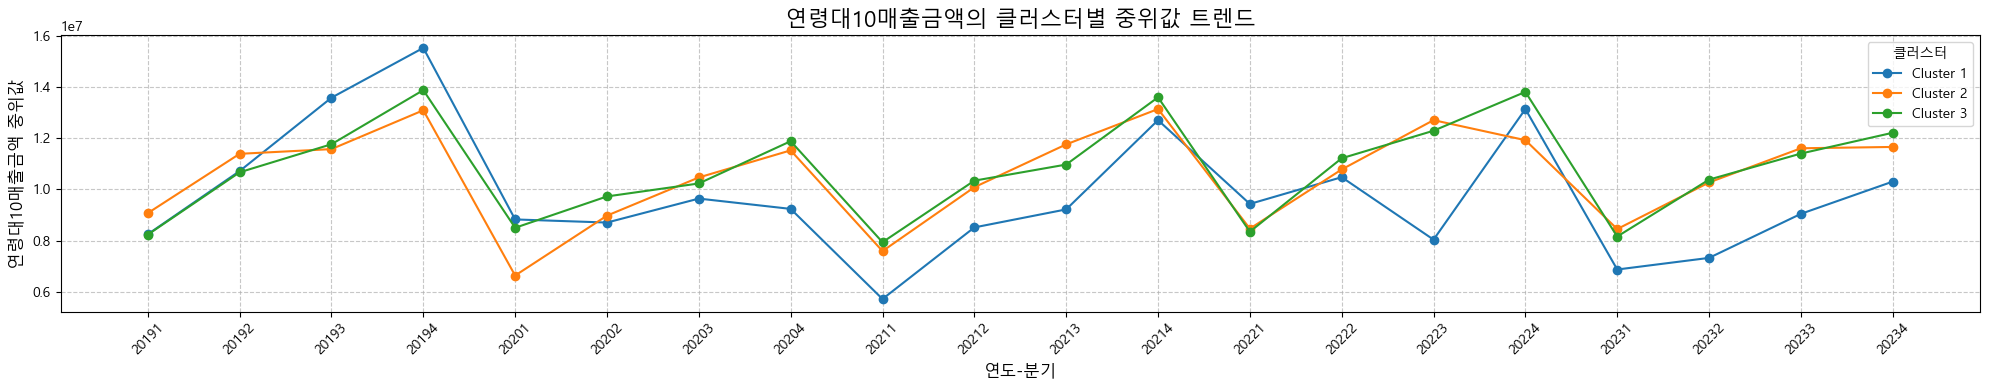

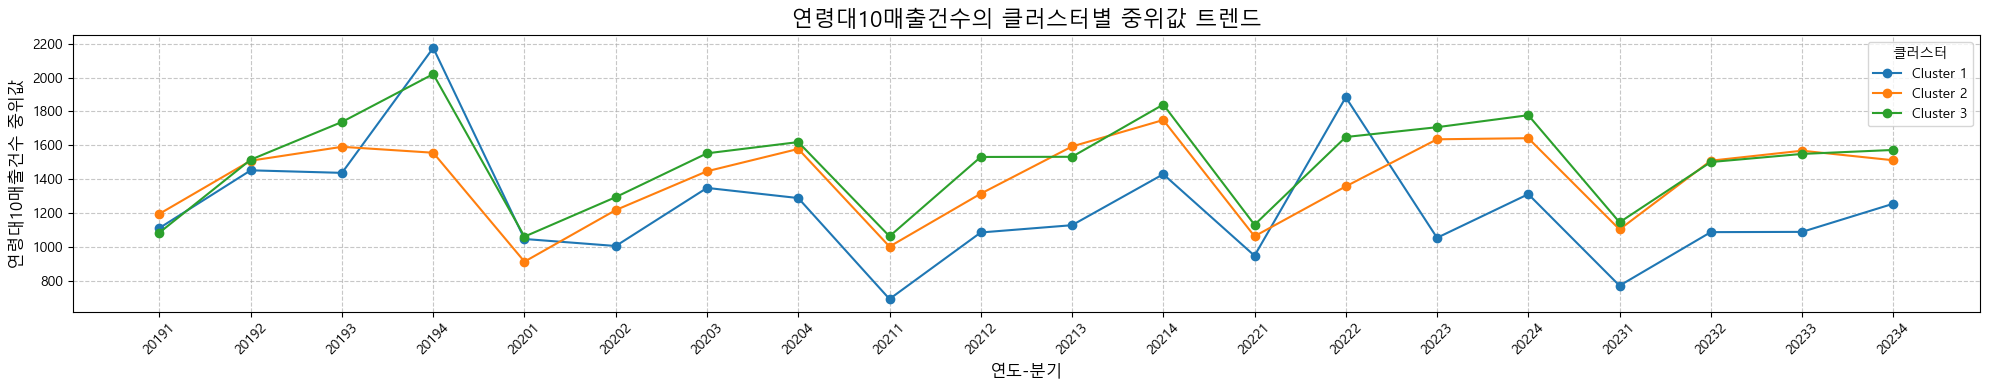

cluster  year quarter period      0       1       2       3
0        2019       1  20191   15.0  1111.0  1195.0  1084.0
1        2019       2  20192   50.0  1452.0  1509.0  1515.0
2        2019       3  20193   70.0  1437.0  1591.0  1738.0
3        2019       4  20194   92.0  2176.0  1556.0  2021.0
4        2020       1  20201   58.0  1046.0   912.0  1060.0
5        2020       2  20202   74.0  1004.5  1217.0  1293.5
6        2020       3  20203  639.0  1348.0  1446.5  1552.5
7        2020       4  20204  669.0  1288.0  1578.5  1619.0
8        2021       1  20211  333.0   691.0  1001.0  1062.0
9        2021       2  20212  529.0  1084.5  1314.0  1531.0
10       2021       3  20213  447.0  1127.5  1593.0  1532.0
11       2021       4  20214  544.0  1429.0  1749.5  1841.0
12       2022       1  20221  591.0   947.0  1062.0  1130.0
13       2022       2  20222  592.0  1884.0  1357.0  1649.0
14       2022       3  20223  417.0  1053.0  1635.5  1707.0
15       2022       4  20224  604.0  1311.0  1642.0  1778.0
16       2023       1  20231  425.0   770.0  1102.5  1144.5
17       2023       2  20232  489.0  1086.5  1509.0  1501.0
18       2023       3  20233  424.0  1088.0  1568.0  1549.0
19       2023       4  20234  233.0  1254.5  1511.5  1572.5

In [10]:
help_me_median(df_final, '연령대10유동인구수')
help_me_median(df_final, '연령대10상주인구수')
help_me_median(df_final, '연령대10매출금액')
help_me_median(df_final, '연령대10매출건수')

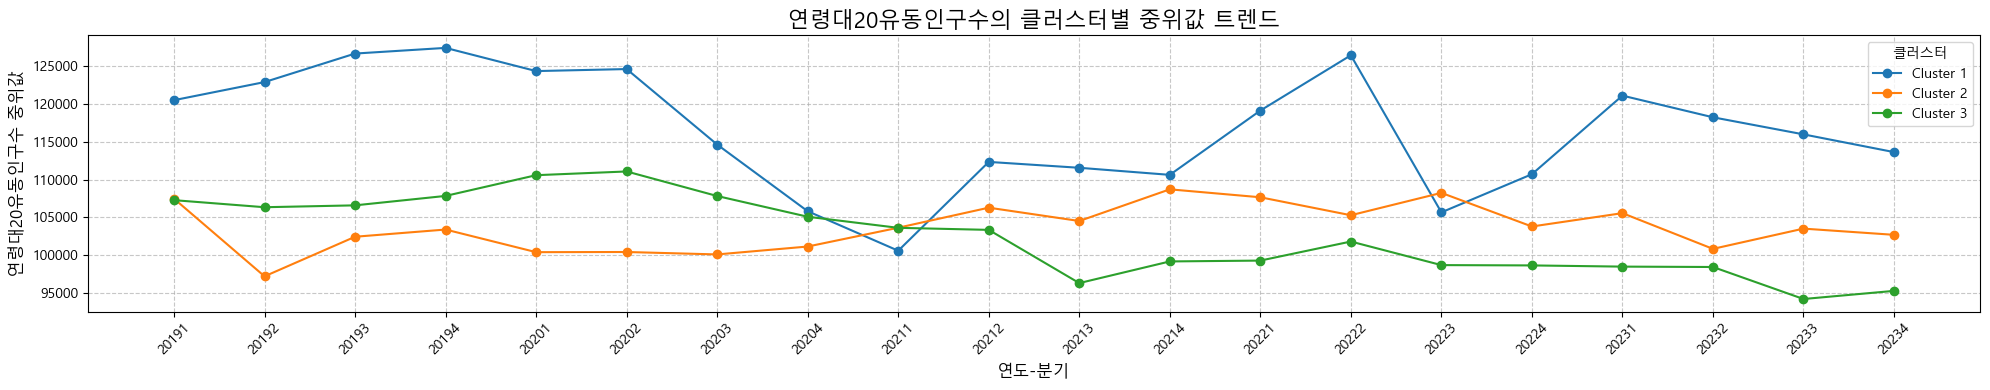

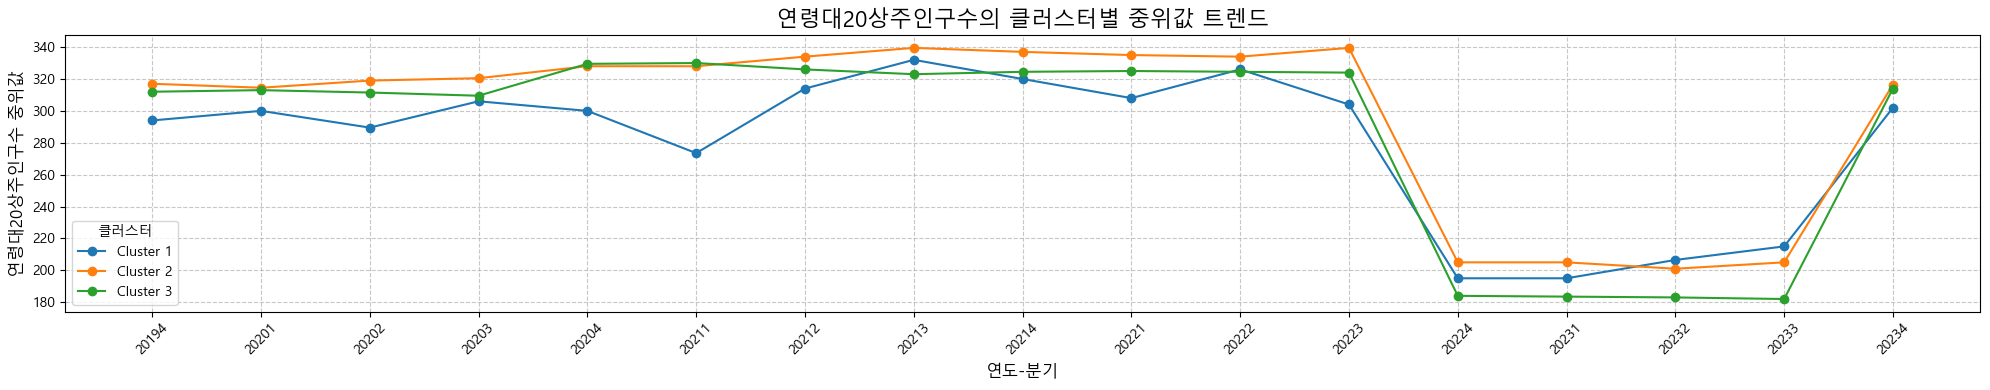

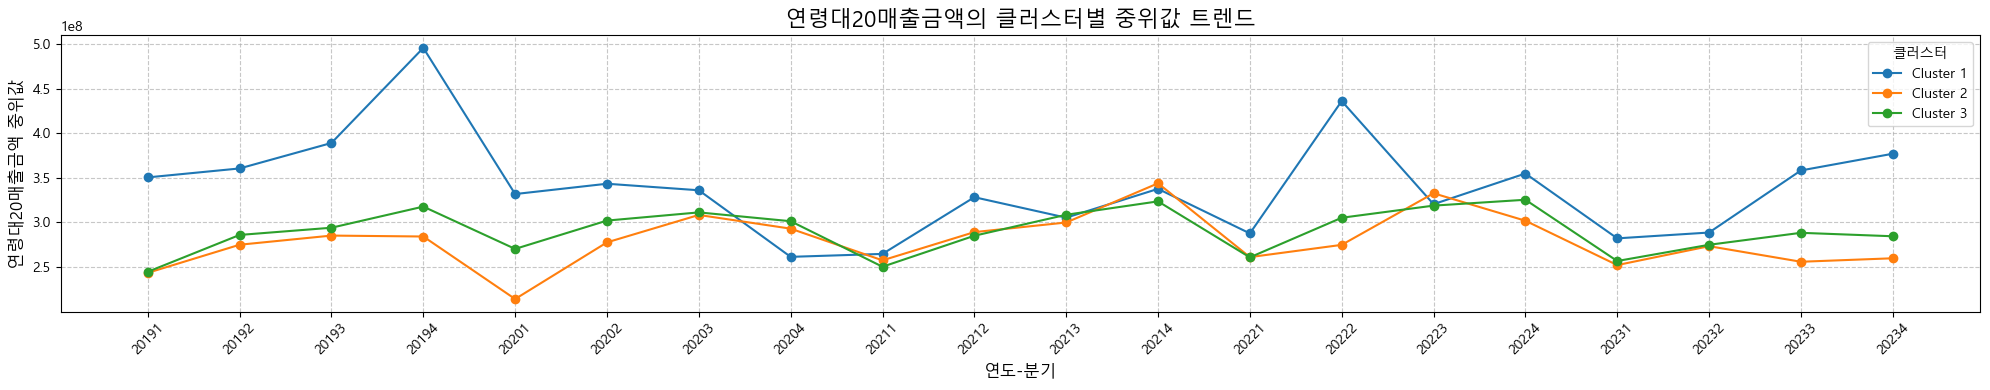

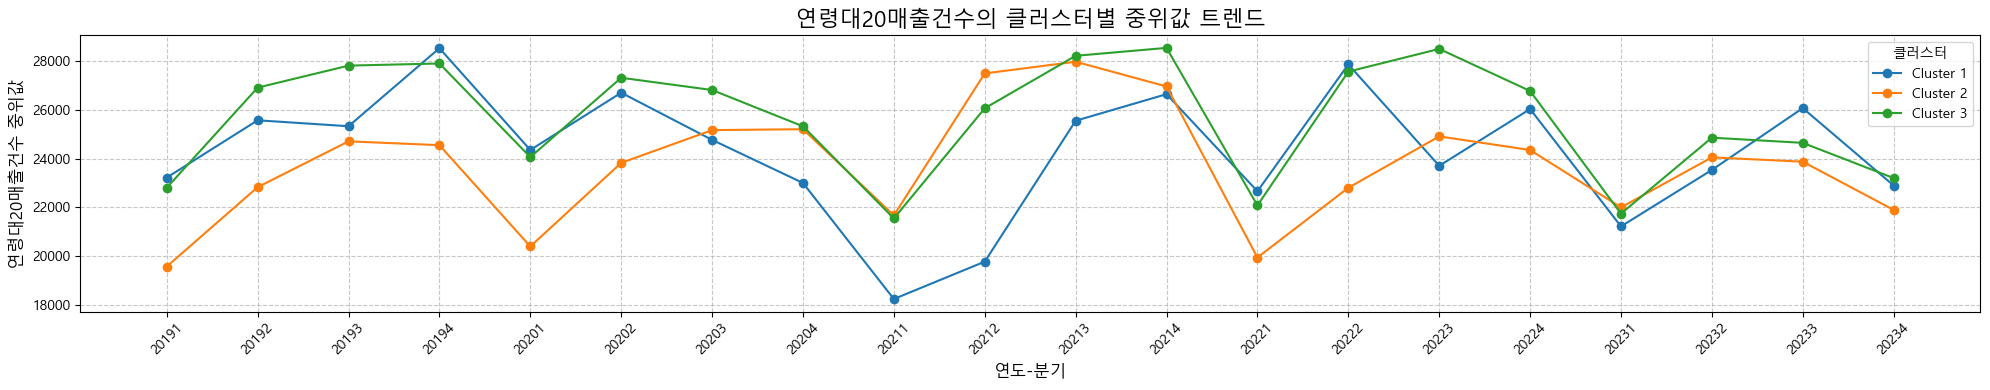

cluster  year quarter period       0        1        2        3
0        2019       1  20191  1931.0  23220.0  19561.5  22803.0
1        2019       2  20192  2284.0  25578.0  22827.5  26922.0
2        2019       3  20193  2526.0  25334.0  24712.0  27827.0
3        2019       4  20194  1907.0  28543.0  24555.0  27915.0
4        2020       1  20201  1617.0  24357.0  20388.5  24063.0
5        2020       2  20202  2162.0  26713.0  23827.0  27327.5
6        2020       3  20203  3231.0  24773.0  25174.0  26823.5
7        2020       4  20204  2211.0  22999.0  25211.5  25330.0
8        2021       1  20211  2090.0  18226.0  21664.5  21541.0
9        2021       2  20212  6367.0  19764.0  27507.0  26072.0
10       2021       3  20213  7342.0  25559.5  27987.0  28231.0
11       2021       4  20214  6776.0  26653.0  26969.0  28556.5
12       2022       1  20221  5577.0  22658.0  19933.0  22076.0
13       2022       2  20222  5983.0  27877.0  22802.0  27580.0
14       2022       3  20223  5815.0  23705.5  24916.0  28514.0
15       2022       4  20224  5044.0  26040.0  24355.0  26785.0
16       2023       1  20231  3289.0  21213.0  21995.5  21738.0
17       2023       2  20232  3835.0  23535.5  24053.5  24863.0
18       2023       3  20233  3748.0  26078.0  23875.0  24650.0
19       2023       4  20234  2709.5  22895.0  21891.5  23201.0

In [11]:
help_me_median(df_final, '연령대20유동인구수')
help_me_median(df_final, '연령대20상주인구수')
help_me_median(df_final, '연령대20매출금액')
help_me_median(df_final, '연령대20매출건수')

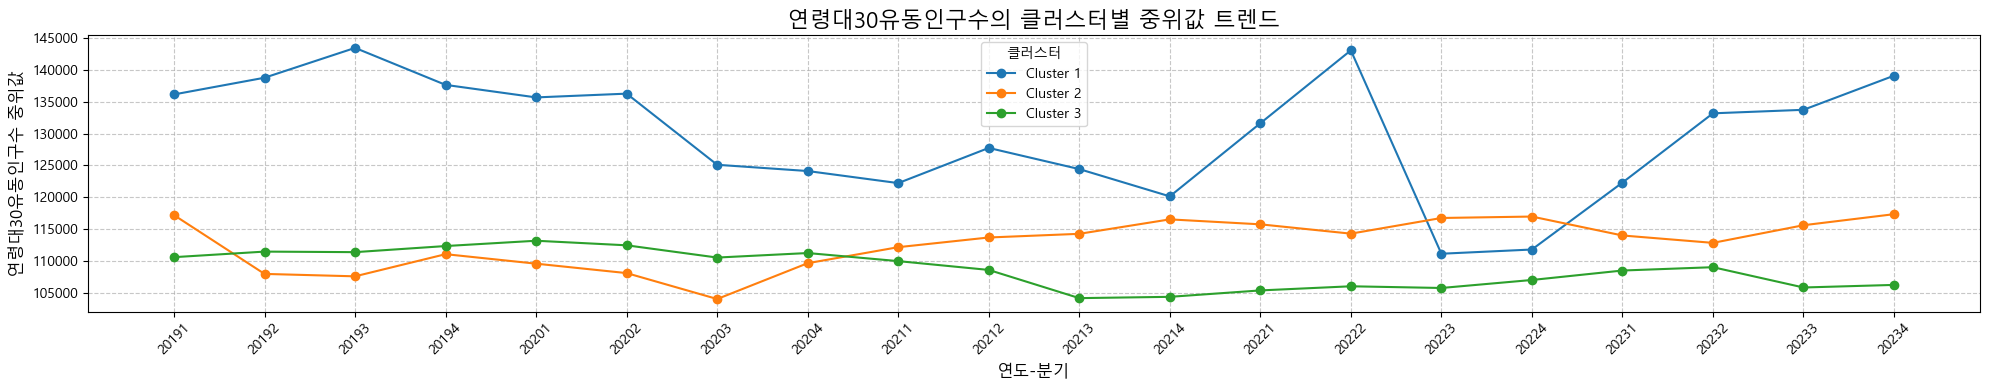

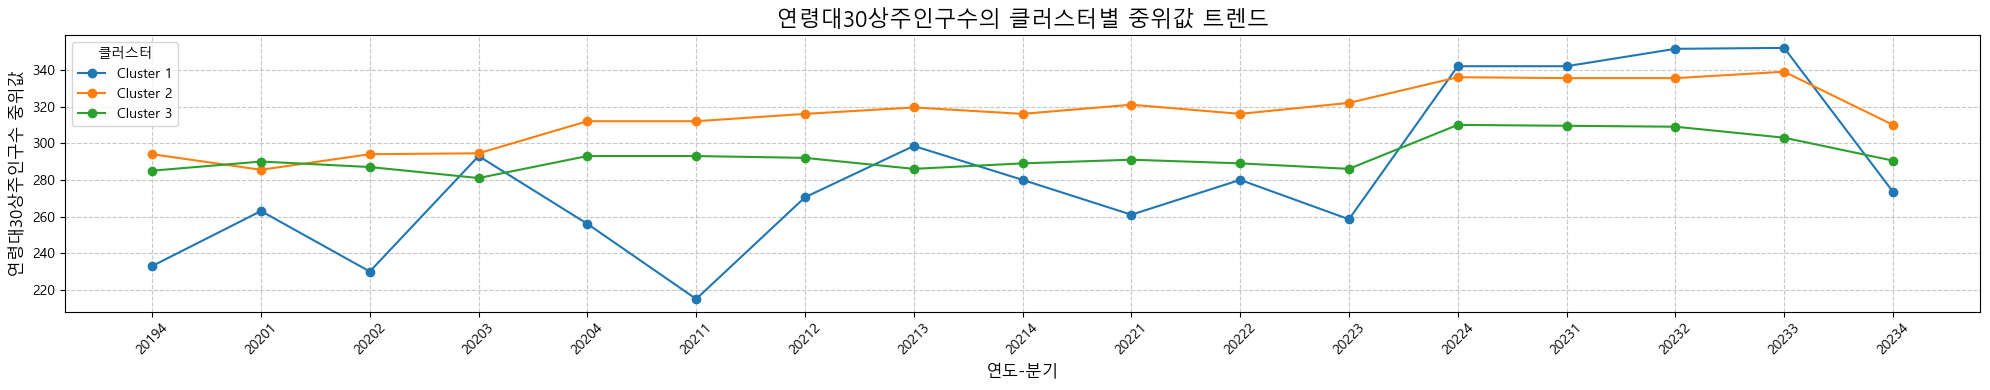

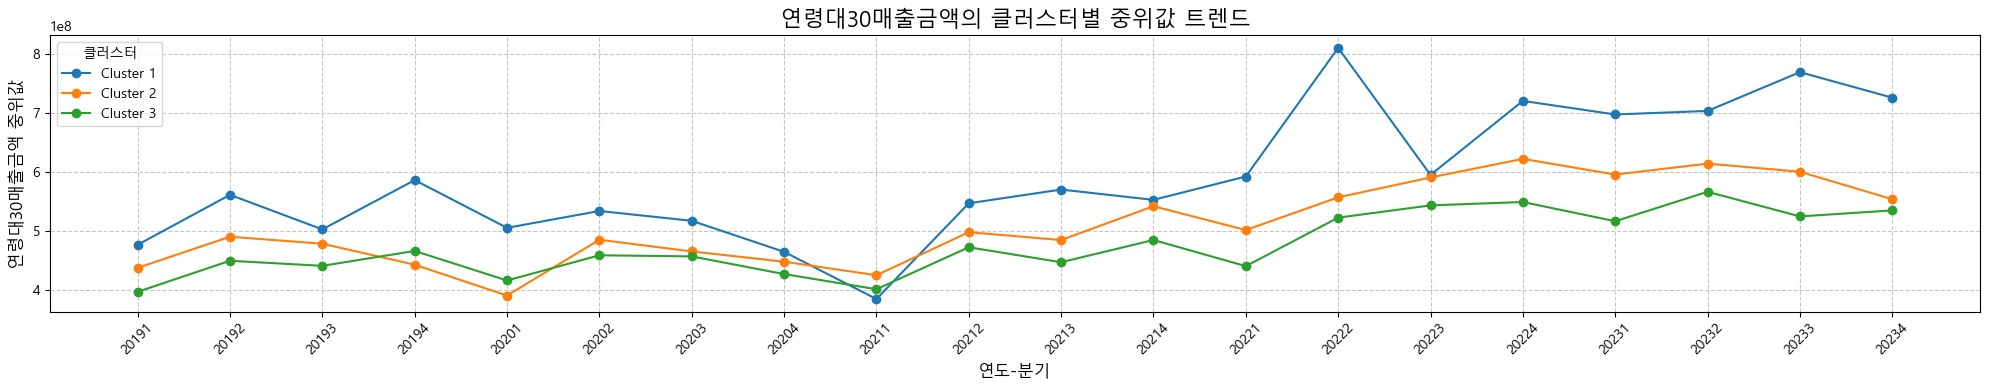

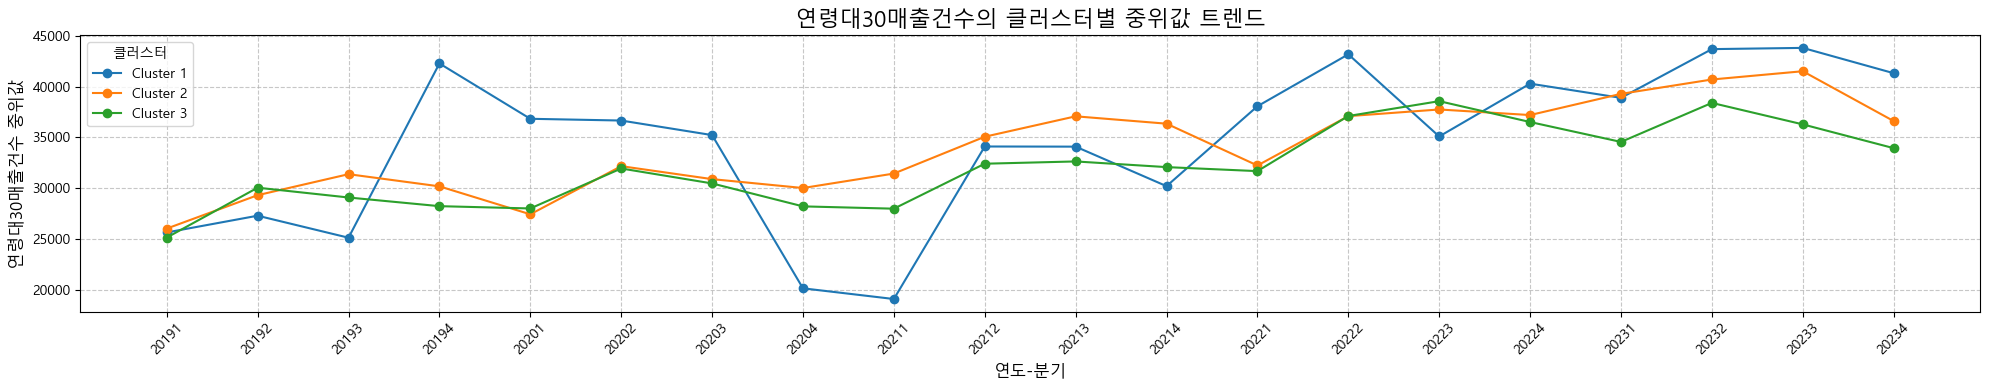

cluster  year quarter period        0        1        2        3
0        2019       1  20191   4585.0  25641.0  26022.5  25135.5
1        2019       2  20192   5962.0  27289.5  29310.0  30047.0
2        2019       3  20193   6821.0  25122.0  31377.0  29082.0
3        2019       4  20194   5253.0  42280.0  30180.0  28229.0
4        2020       1  20201   4106.0  36831.5  27427.5  28003.0
5        2020       2  20202   5092.0  36659.5  32167.0  31939.5
6        2020       3  20203   5887.0  35226.0  30890.5  30467.5
7        2020       4  20204   3921.0  20140.0  30015.5  28208.0
8        2021       1  20211   3731.0  19087.0  31439.0  27981.0
9        2021       2  20212  17001.0  34104.0  35064.5  32408.0
10       2021       3  20213  17485.0  34089.5  37075.0  32632.0
11       2021       4  20214  15473.0  30199.0  36350.5  32074.0
12       2022       1  20221  17216.0  38065.0  32233.0  31679.0
13       2022       2  20222  16627.0  43178.0  37093.0  37105.5
14       2022       3  20223  15659.0  35090.5  37748.5  38567.0
15       2022       4  20224  13524.0  40291.0  37199.0  36513.0
16       2023       1  20231  13724.0  38893.0  39285.5  34553.5
17       2023       2  20232  13616.0  43690.5  40700.0  38395.0
18       2023       3  20233  11500.0  43812.0  41514.0  36282.0
19       2023       4  20234   7542.5  41321.5  36609.0  33941.0

In [12]:
help_me_median(df_final, '연령대30유동인구수')
help_me_median(df_final, '연령대30상주인구수')
help_me_median(df_final, '연령대30매출금액')
help_me_median(df_final, '연령대30매출건수')

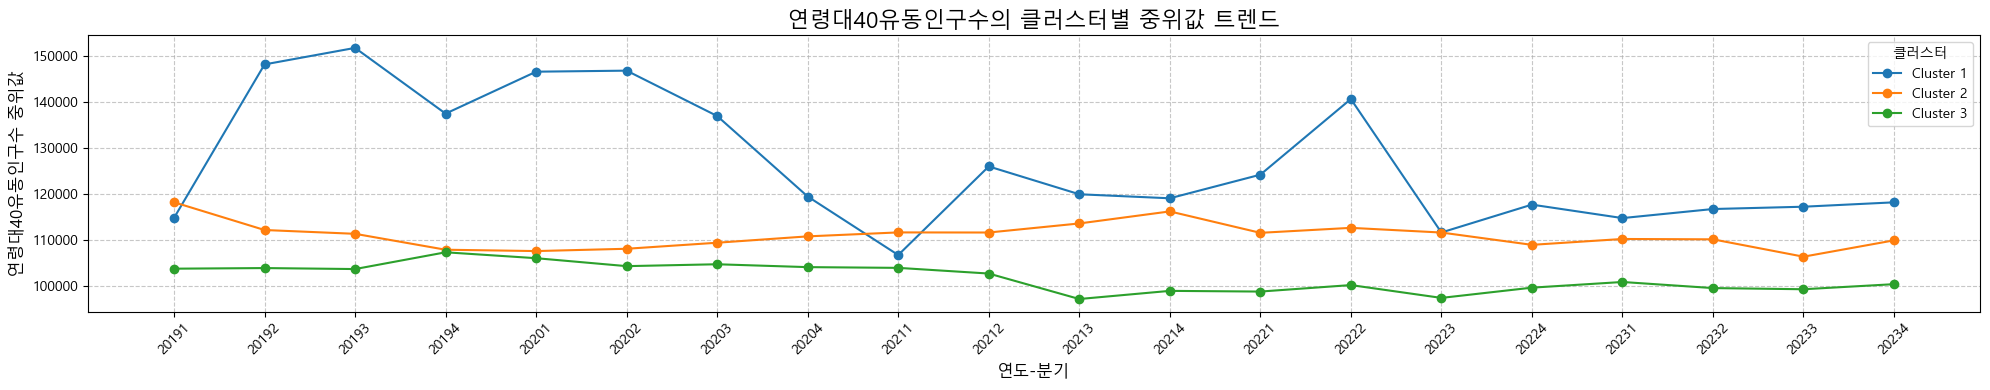

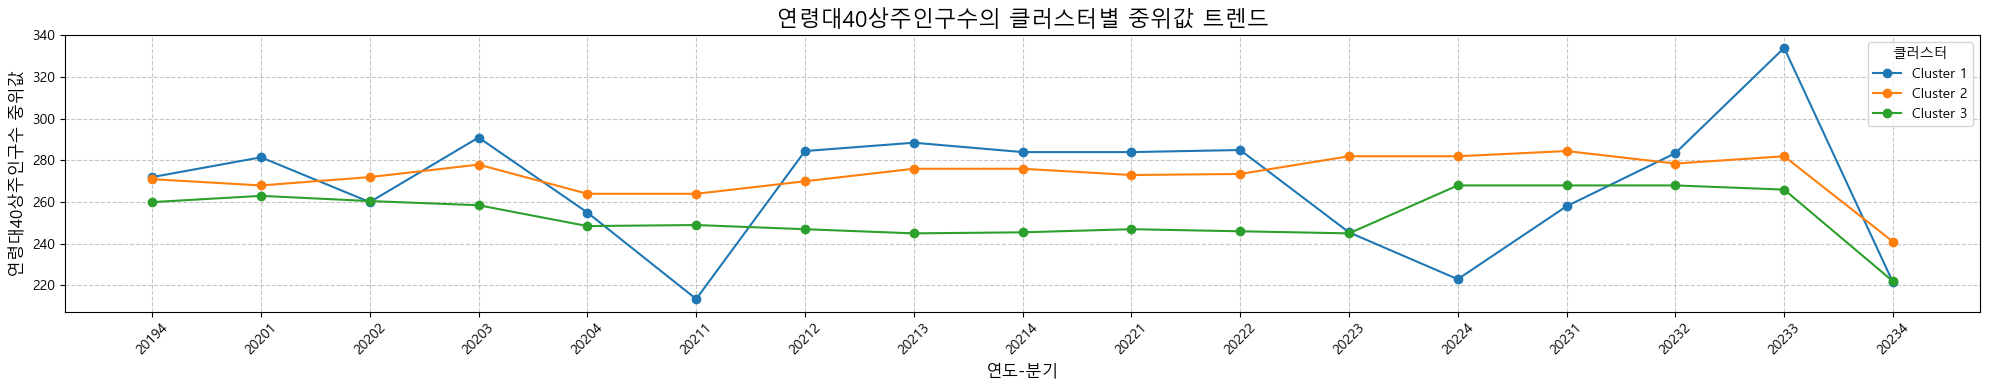

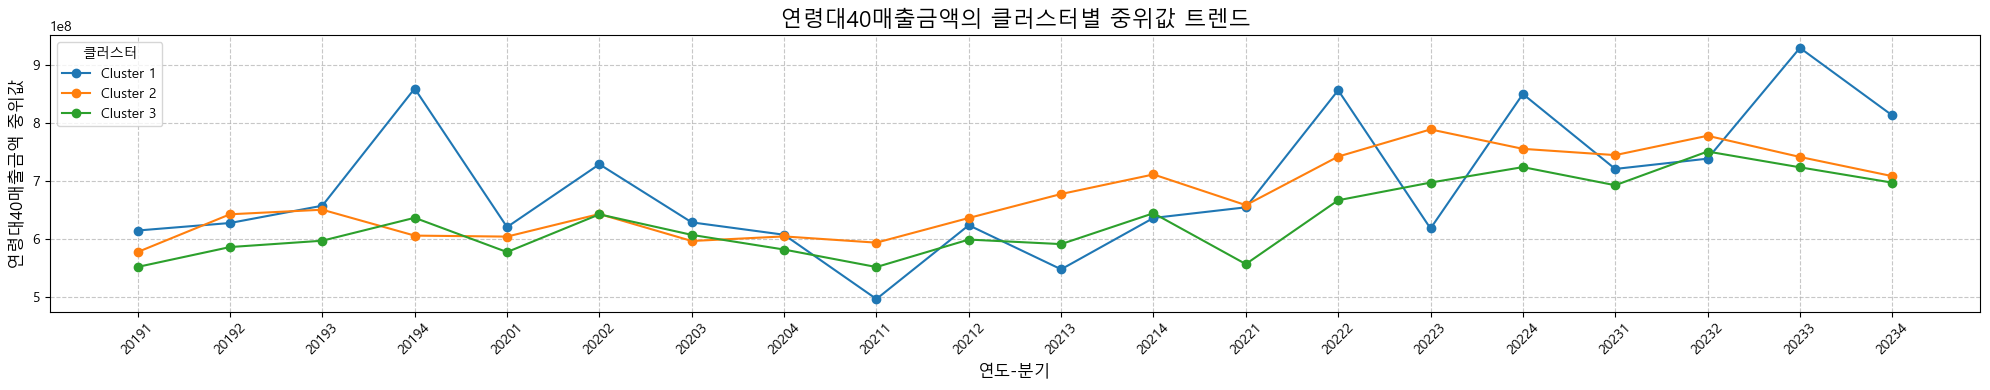

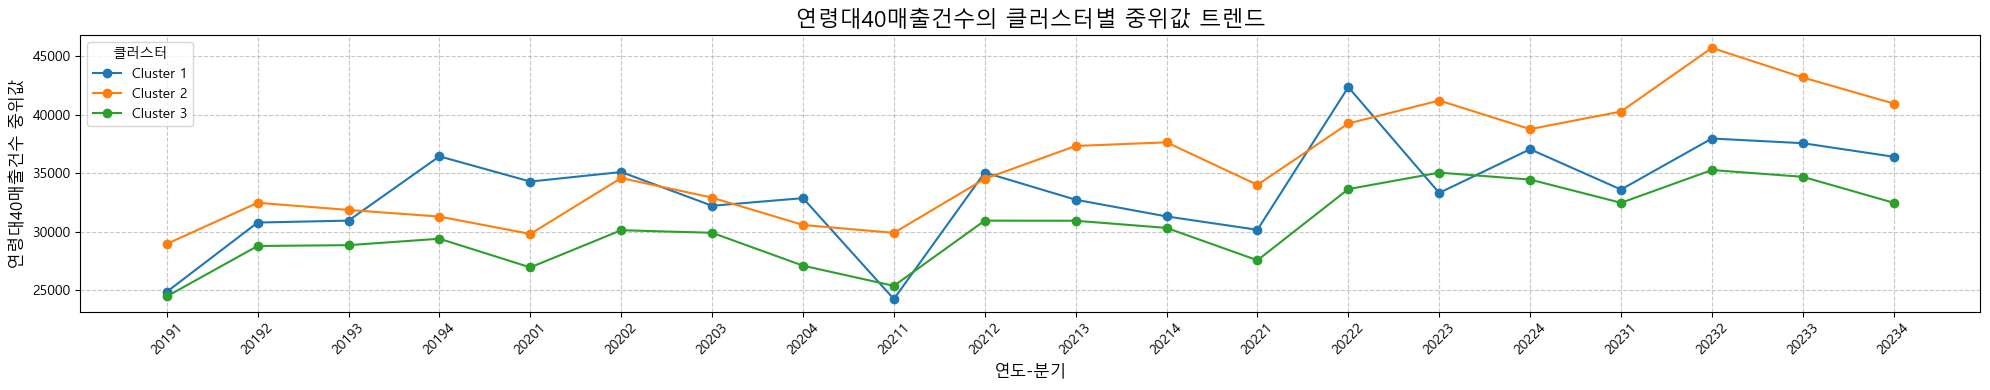

cluster  year quarter period        0        1        2        3
0        2019       1  20191   9565.0  24866.0  28960.0  24477.0
1        2019       2  20192  10317.0  30780.5  32468.5  28780.0
2        2019       3  20193  10214.0  30946.0  31855.0  28852.0
3        2019       4  20194  10142.0  36434.0  31291.0  29398.0
4        2020       1  20201   8939.0  34280.5  29807.5  26954.0
5        2020       2  20202   8501.0  35094.0  34580.0  30126.5
6        2020       3  20203   8851.0  32214.0  32907.0  29907.0
7        2020       4  20204   6117.0  32865.0  30575.5  27100.5
8        2021       1  20211   5791.0  24253.5  29901.0  25375.0
9        2021       2  20212  18360.0  35053.5  34512.0  30945.0
10       2021       3  20213  17386.0  32731.5  37318.0  30935.0
11       2021       4  20214  14852.0  31305.0  37628.0  30323.5
12       2022       1  20221  16109.0  30162.0  34001.0  27560.0
13       2022       2  20222  15876.0  42341.0  39236.5  33636.5
14       2022       3  20223  14737.0  33311.5  41198.0  35042.0
15       2022       4  20224  14109.0  37041.0  38754.0  34451.0
16       2023       1  20231  13234.0  33598.0  40256.5  32467.0
17       2023       2  20232  11212.0  37954.0  45691.0  35262.0
18       2023       3  20233  11323.0  37556.0  43165.0  34686.0
19       2023       4  20234   8487.5  36398.0  40941.0  32469.0

In [13]:
help_me_median(df_final, '연령대40유동인구수')
help_me_median(df_final, '연령대40상주인구수')
help_me_median(df_final, '연령대40매출금액')
help_me_median(df_final, '연령대40매출건수')

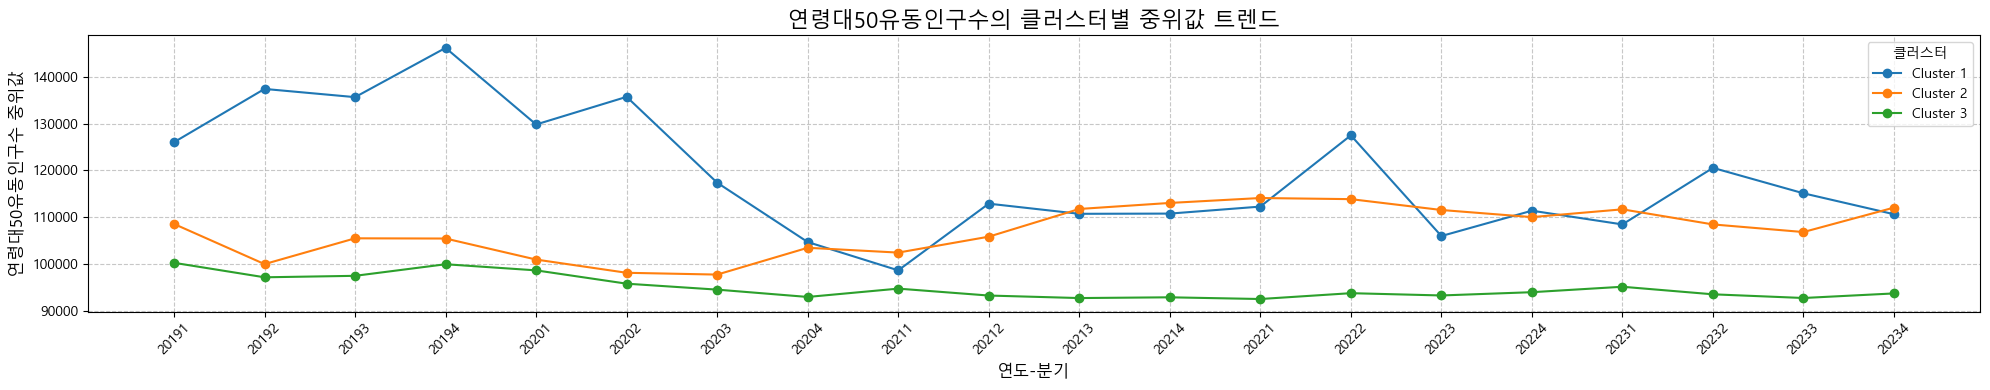

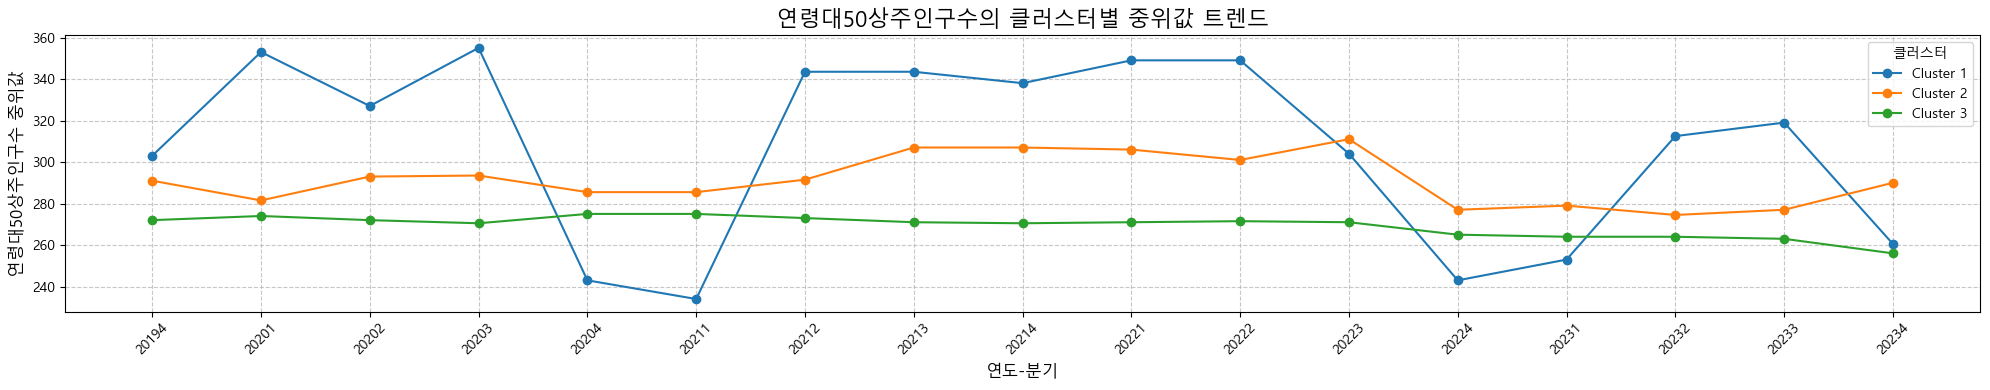

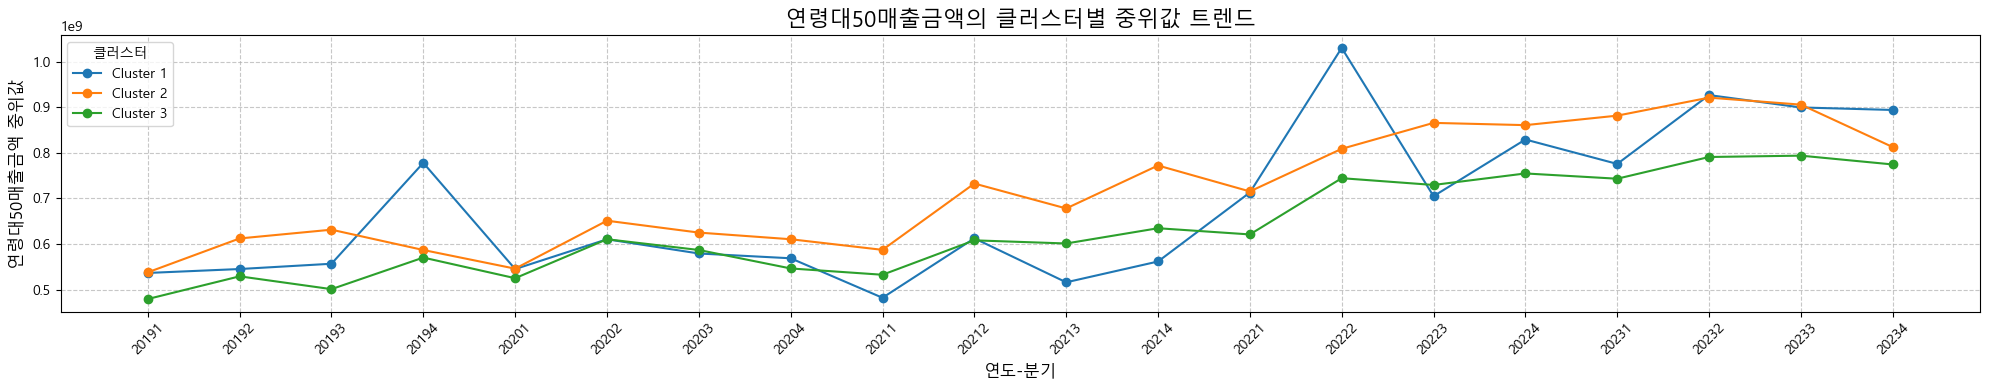

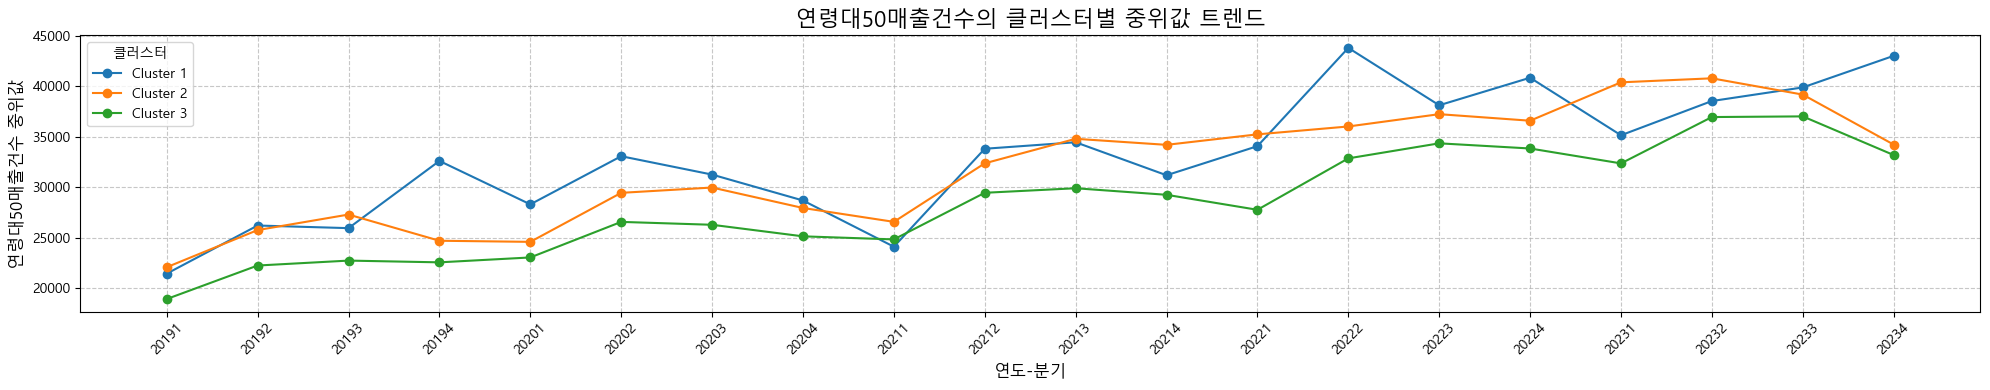

cluster  year quarter period        0        1        2        3
0        2019       1  20191   7501.0  21430.0  22066.5  18914.5
1        2019       2  20192   7680.0  26196.5  25746.0  22233.0
2        2019       3  20193   7500.0  25937.0  27284.0  22721.0
3        2019       4  20194   8236.0  32597.0  24688.0  22548.0
4        2020       1  20201   6994.0  28293.5  24578.0  23033.0
5        2020       2  20202   8095.0  33064.0  29435.0  26556.0
6        2020       3  20203   7450.0  31243.0  29960.5  26269.5
7        2020       4  20204   5244.0  28676.0  27934.5  25125.0
8        2021       1  20211   4730.0  24097.5  26560.0  24821.0
9        2021       2  20212  12411.0  33803.0  32359.5  29440.0
10       2021       3  20213  13923.0  34445.5  34788.5  29890.0
11       2021       4  20214  13046.0  31178.0  34190.5  29240.0
12       2022       1  20221  13986.0  34059.0  35229.0  27755.0
13       2022       2  20222  14925.0  43797.0  36010.5  32850.5
14       2022       3  20223  13471.0  38111.5  37229.5  34341.0
15       2022       4  20224  12345.0  40840.0  36581.0  33829.0
16       2023       1  20231  12421.0  35140.0  40384.5  32352.0
17       2023       2  20232  11248.0  38531.0  40782.5  36944.0
18       2023       3  20233   9169.0  39879.0  39169.0  37010.0
19       2023       4  20234   7223.5  43009.5  34217.5  33181.0

In [14]:
help_me_median(df_final, '연령대50유동인구수')
help_me_median(df_final, '연령대50상주인구수')
help_me_median(df_final, '연령대50매출금액')
help_me_median(df_final, '연령대50매출건수')

# Case 6 : 성별별

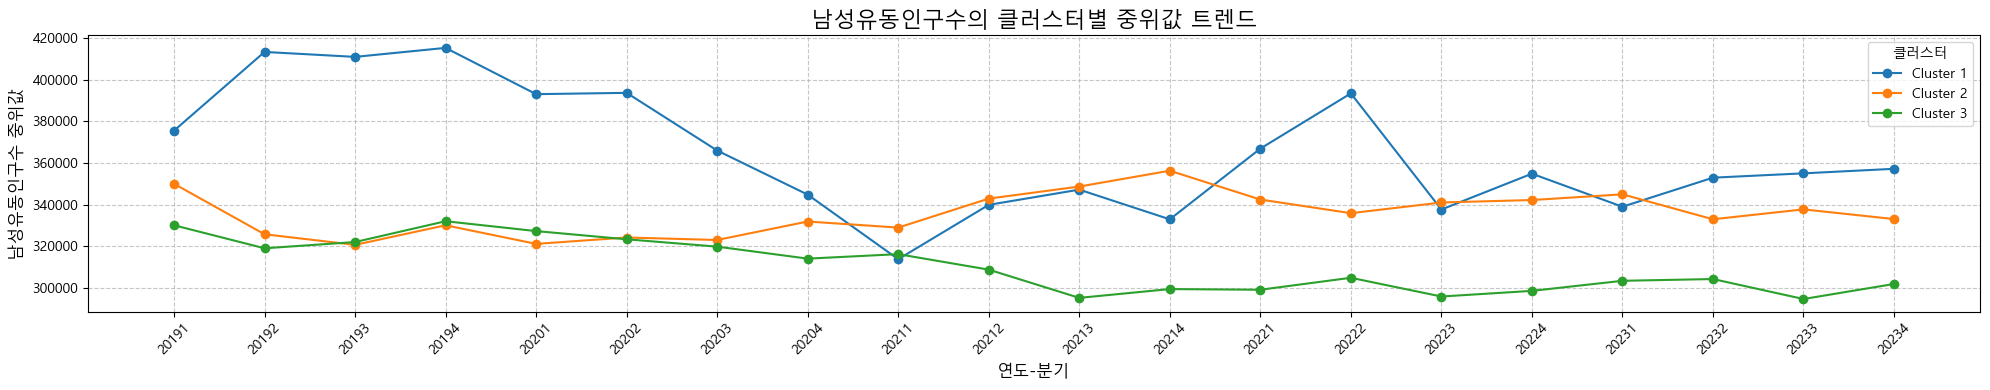

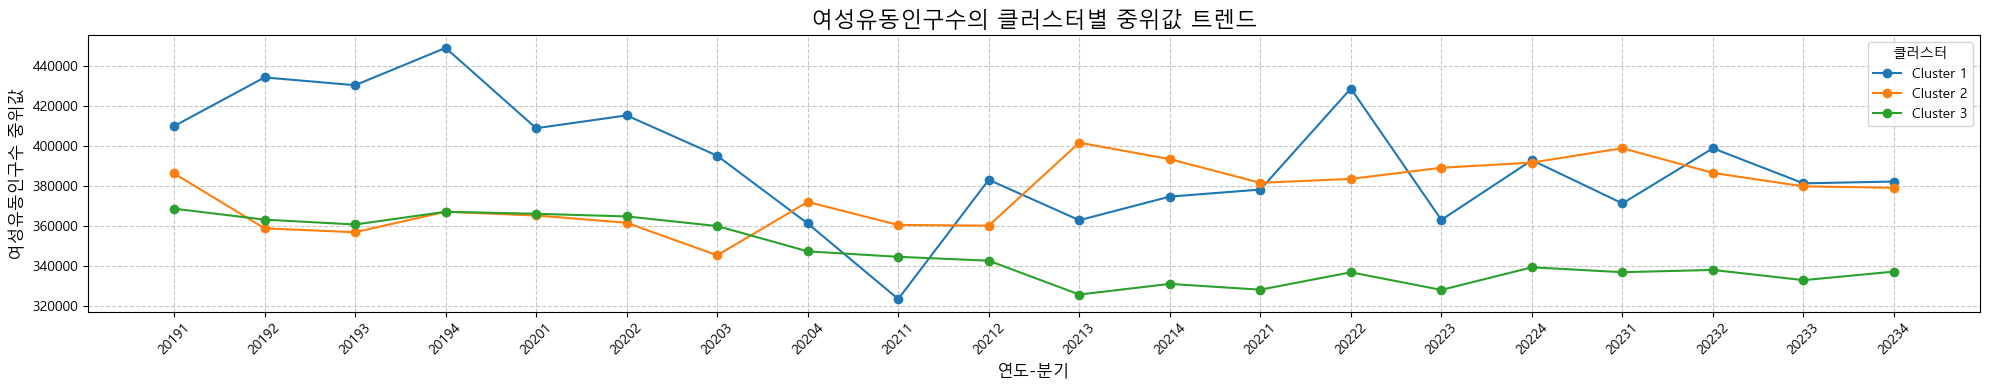

cluster  year quarter period         0         1         2         3
0        2019       1  20191  148641.0  409724.0  386076.0  368484.0
1        2019       2  20192  135800.0  434073.5  358657.5  362999.0
2        2019       3  20193  130531.0  430175.0  356704.0  360574.0
3        2019       4  20194  137497.0  448831.0  366951.0  366929.0
4        2020       1  20201  143014.0  408694.5  365069.0  365923.0
5        2020       2  20202  136890.0  415089.5  361450.0  364599.5
6        2020       3  20203  135043.0  394947.0  345170.5  359805.5
7        2020       4  20204  129041.0  361081.0  371864.0  347157.5
8        2021       1  20211  127343.0  323332.0  360334.5  344421.0
9        2021       2  20212  131238.0  382910.5  360003.0  342475.0
10       2021       3  20213  123570.0  362714.5  401460.5  325574.0
11       2021       4  20214  118287.0  374517.0  393231.0  330885.5
12       2022       1  20221  114877.0  378028.0  381403.0  327996.0
13       2022       2  20222  112771.0  428524.0  383370.0  336683.5
14       2022       3  20223  324508.0  362881.0  388921.5  327884.0
15       2022       4  20224  327448.0  392726.0  391521.0  339167.0
16       2023       1  20231  330257.0  371108.0  398689.0  336738.0
17       2023       2  20232  328056.0  398669.5  386356.0  337866.0
18       2023       3  20233  317152.0  381144.0  379634.0  332755.0
19       2023       4  20234  229353.5  382037.5  378900.5  337026.5

In [15]:
help_me_median(df_final, '남성유동인구수')
help_me_median(df_final, '여성유동인구수')

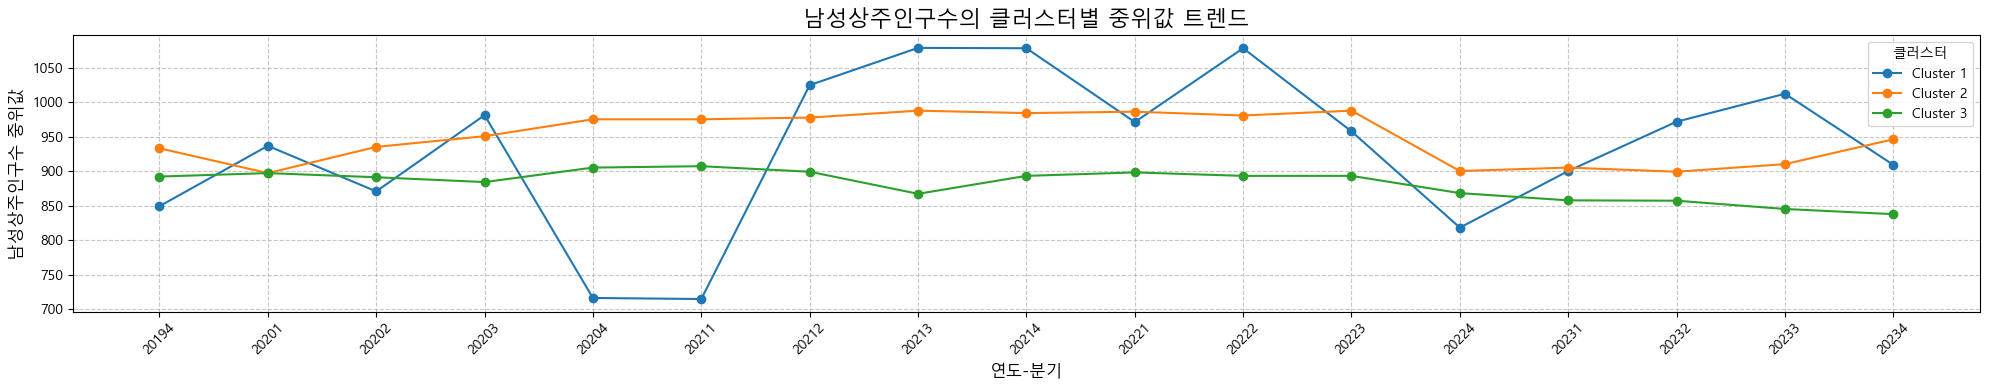

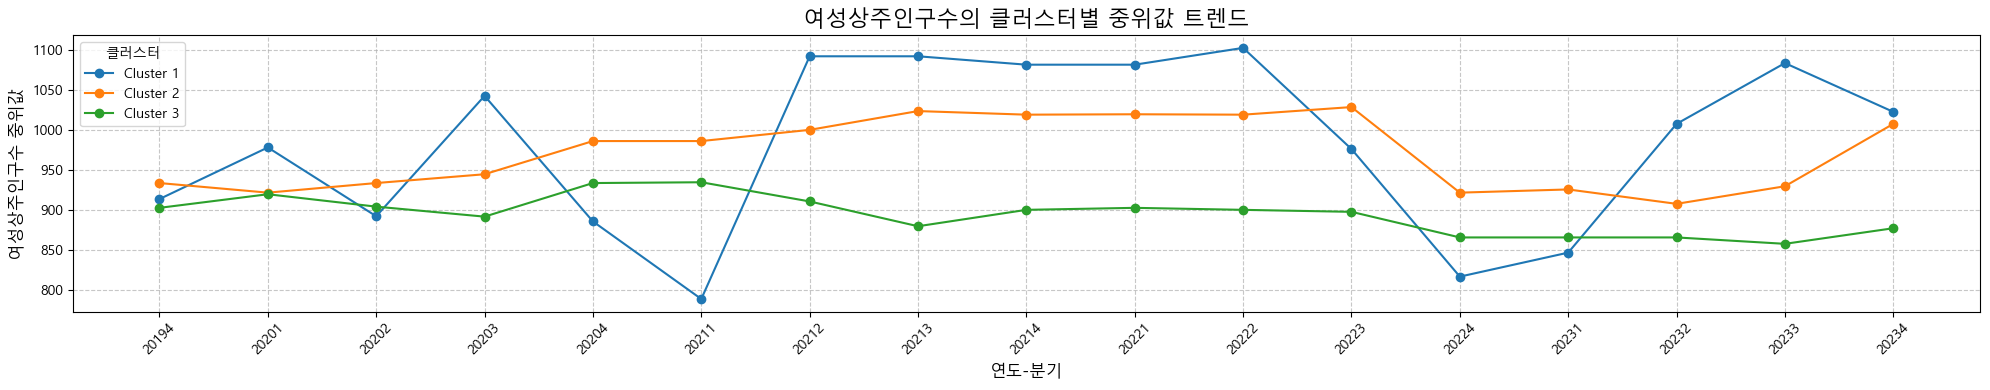

cluster  year quarter period       0       1       2      3
0        2019       4  20194  1058.0   914.0   934.0  903.0
1        2020       1  20201  1058.0   978.5   922.0  920.0
2        2020       2  20202  1058.0   892.5   934.0  904.5
3        2020       3  20203  1058.0  1043.0   945.0  892.0
4        2020       4  20204   476.0   886.0   986.5  934.0
5        2021       1  20211   476.0   789.0   986.5  935.0
6        2021       2  20212  1045.0  1092.5  1000.5  911.0
7        2021       3  20213  1045.0  1092.5  1024.0  880.0
8        2021       4  20214  1045.0  1082.0  1019.5  900.5
9        2022       1  20221  1045.0  1082.0  1020.0  903.0
10       2022       2  20222  1045.0  1103.0  1019.5  900.5
11       2022       3  20223  1082.0   976.5  1029.0  898.0
12       2022       4  20224  1099.0   817.0   922.0  866.0
13       2023       1  20231  1099.0   847.0   926.0  866.0
14       2023       2  20232  1099.0  1008.0   908.0  866.0
15       2023       3  20233  1099.0  1084.0   930.0  858.0
16       2023       4  20234  1329.0  1023.0  1008.0  877.5

In [16]:
help_me_median(df_final, '남성상주인구수')
help_me_median(df_final, '여성상주인구수')

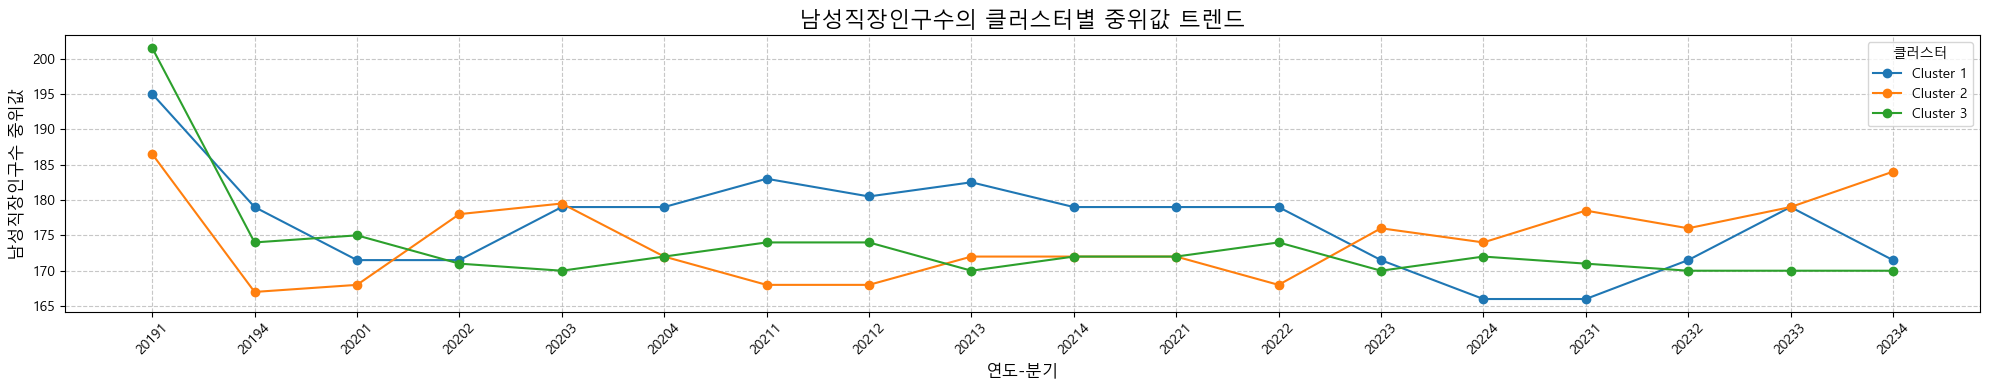

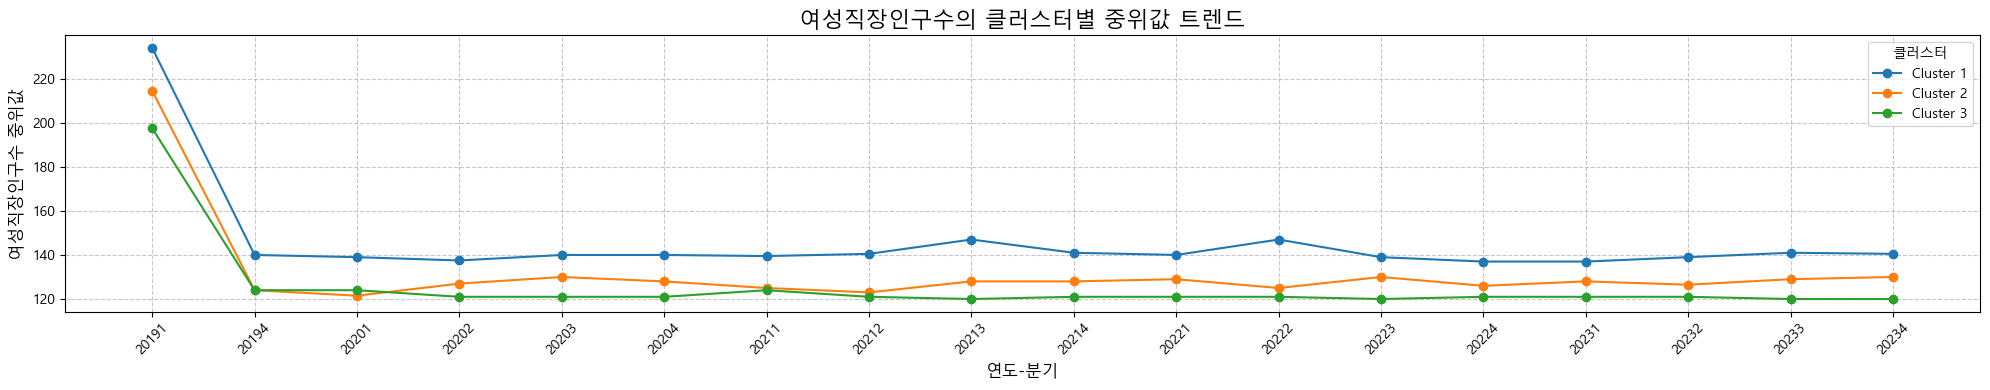

cluster  year quarter period      0      1      2      3
0        2019       1  20191  107.0  234.0  214.5  197.5
1        2019       4  20194   96.0  140.0  124.0  124.0
2        2020       1  20201   96.0  139.0  121.5  124.0
3        2020       2  20202   96.0  137.5  127.0  121.0
4        2020       3  20203   96.0  140.0  130.0  121.0
5        2020       4  20204   27.0  140.0  128.0  121.0
6        2021       1  20211   27.0  139.5  125.0  124.0
7        2021       2  20212   96.0  140.5  123.0  121.0
8        2021       3  20213   96.0  147.0  128.0  120.0
9        2021       4  20214   96.0  141.0  128.0  121.0
10       2022       1  20221   96.0  140.0  129.0  121.0
11       2022       2  20222   96.0  147.0  125.0  121.0
12       2022       3  20223  302.0  139.0  130.0  120.0
13       2022       4  20224  302.0  137.0  126.0  121.0
14       2023       1  20231  302.0  137.0  128.0  121.0
15       2023       2  20232  302.0  139.0  126.5  121.0
16       2023       3  20233  302.0  141.0  129.0  120.0
17       2023       4  20234  199.0  140.5  130.0  120.0

In [17]:
help_me_median(df_final, '남성직장인구수')
help_me_median(df_final, '여성직장인구수')

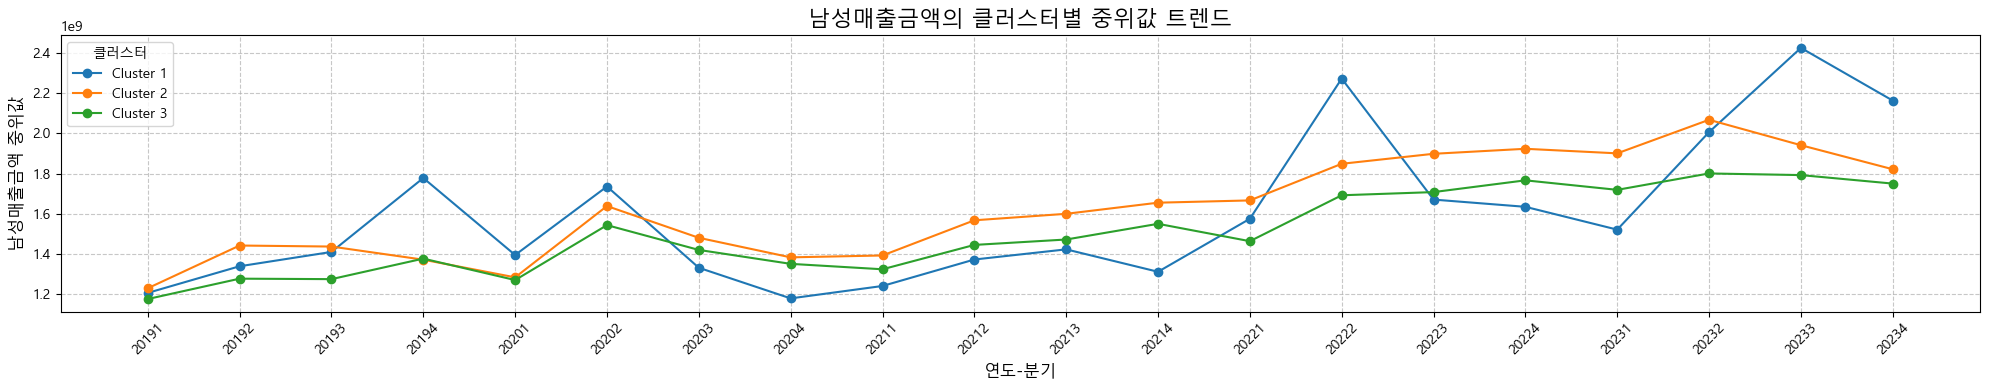

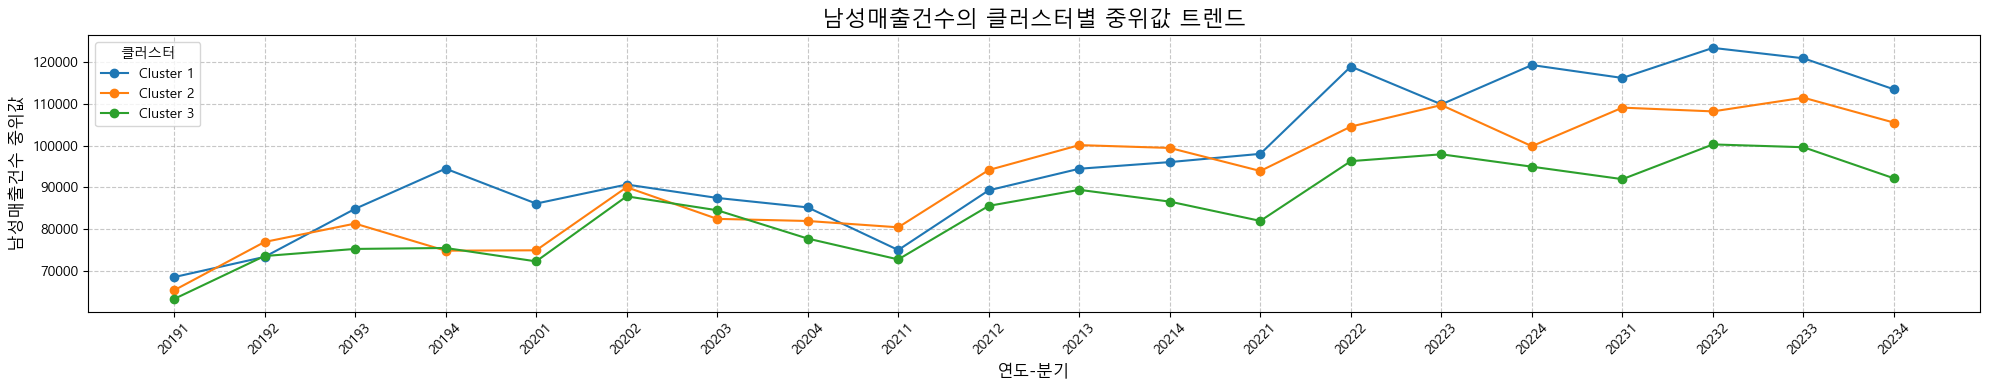

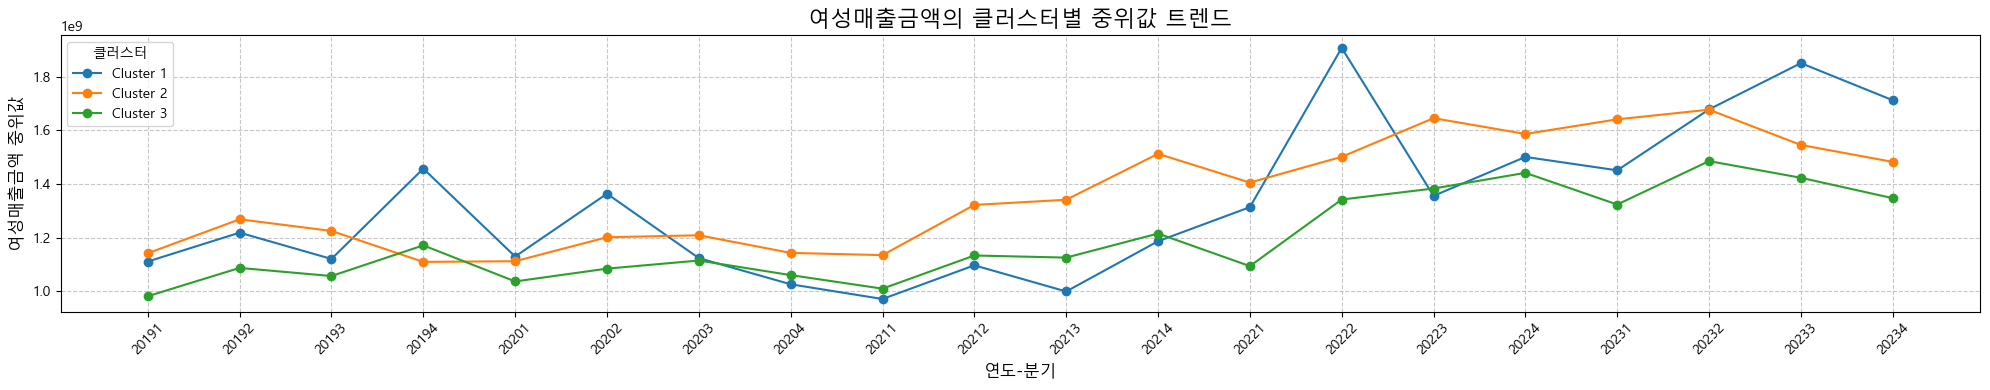

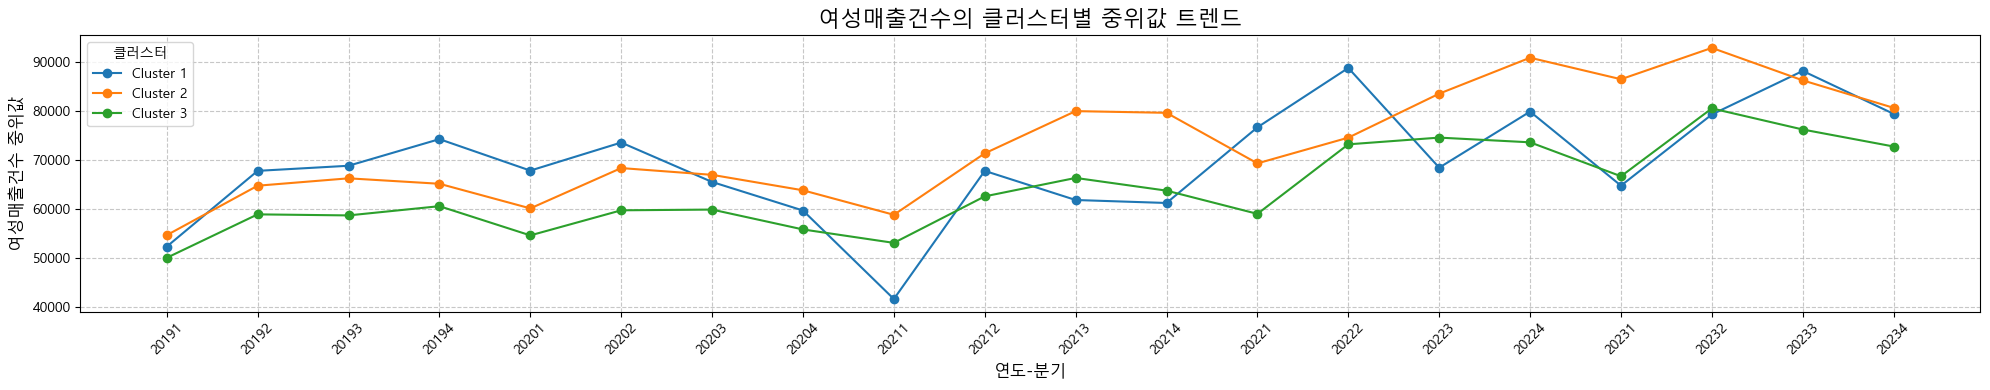

cluster  year quarter period        0        1        2        3
0        2019       1  20191  14873.0  52233.0  54572.0  49949.5
1        2019       2  20192  16781.0  67711.0  64677.0  58822.0
2        2019       3  20193  17702.0  68751.0  66185.0  58608.0
3        2019       4  20194  16842.0  74190.0  65073.0  60494.0
4        2020       1  20201  16409.0  67763.5  60043.0  54527.0
5        2020       2  20202  13818.0  73494.0  68281.0  59651.0
6        2020       3  20203  13650.0  65441.0  66897.0  59800.0
7        2020       4  20204   9192.0  59608.0  63738.0  55742.0
8        2021       1  20211   8444.0  41530.0  58734.0  52998.0
9        2021       2  20212  41141.0  67704.5  71286.0  62498.0
10       2021       3  20213  38486.0  61756.0  79914.5  66266.0
11       2021       4  20214  32194.0  61148.0  79564.5  63669.5
12       2022       1  20221  34253.0  76602.0  69239.0  58925.0
13       2022       2  20222  34264.0  88732.0  74496.0  73129.5
14       2022       3  20223  31982.0  68362.5  83479.0  74502.0
15       2022       4  20224  29440.0  79815.0  90822.0  73540.0
16       2023       1  20231  28169.0  64686.0  86425.5  66606.0
17       2023       2  20232  29288.0  79228.5  92830.0  80468.0
18       2023       3  20233  27043.0  88123.0  86196.0  76156.0
19       2023       4  20234  17510.0  79350.0  80579.0  72683.0

In [18]:
help_me_median(df_final, '남성매출금액')
help_me_median(df_final, '남성매출건수')

help_me_median(df_final, '여성매출금액')
help_me_median(df_final, '여성매출건수')

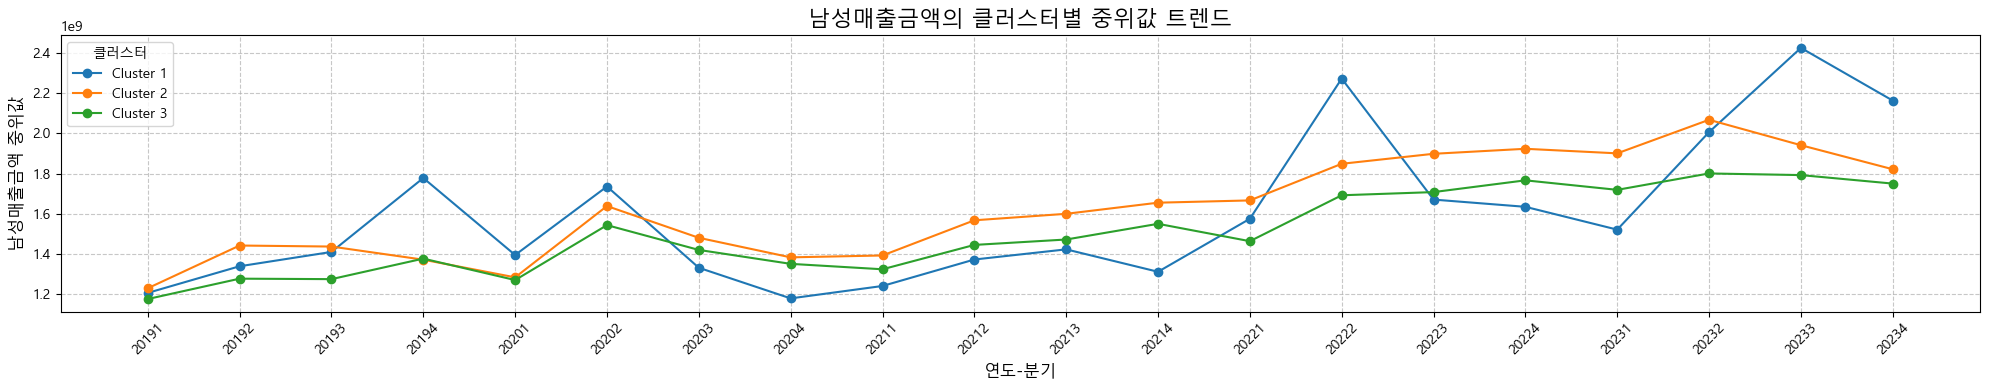

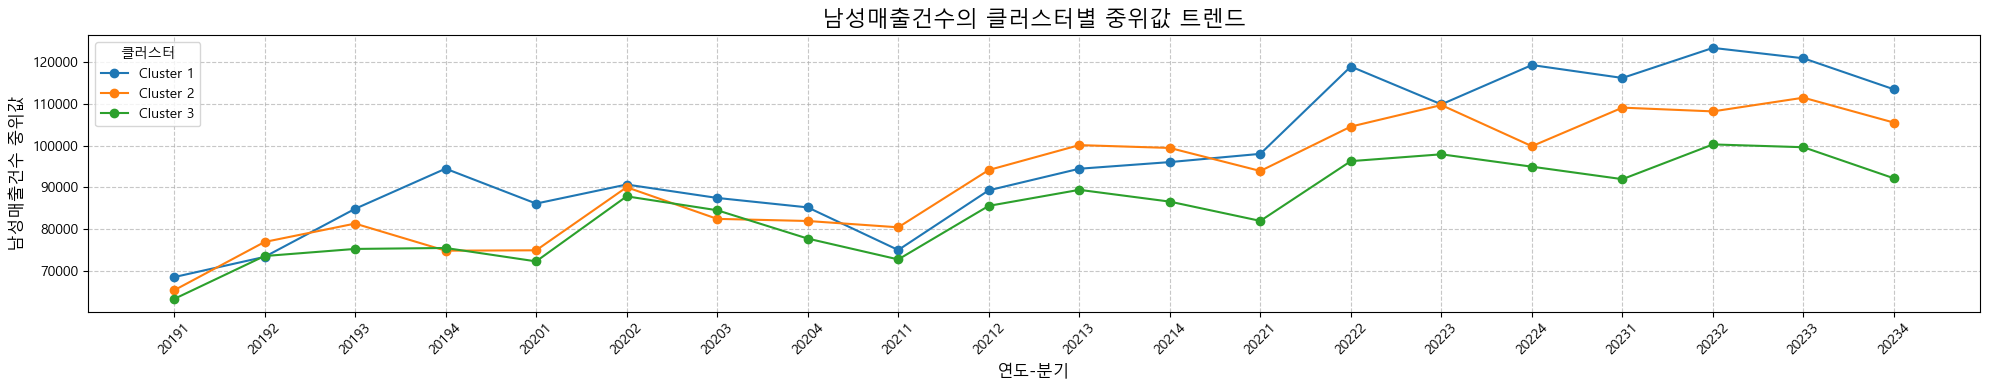

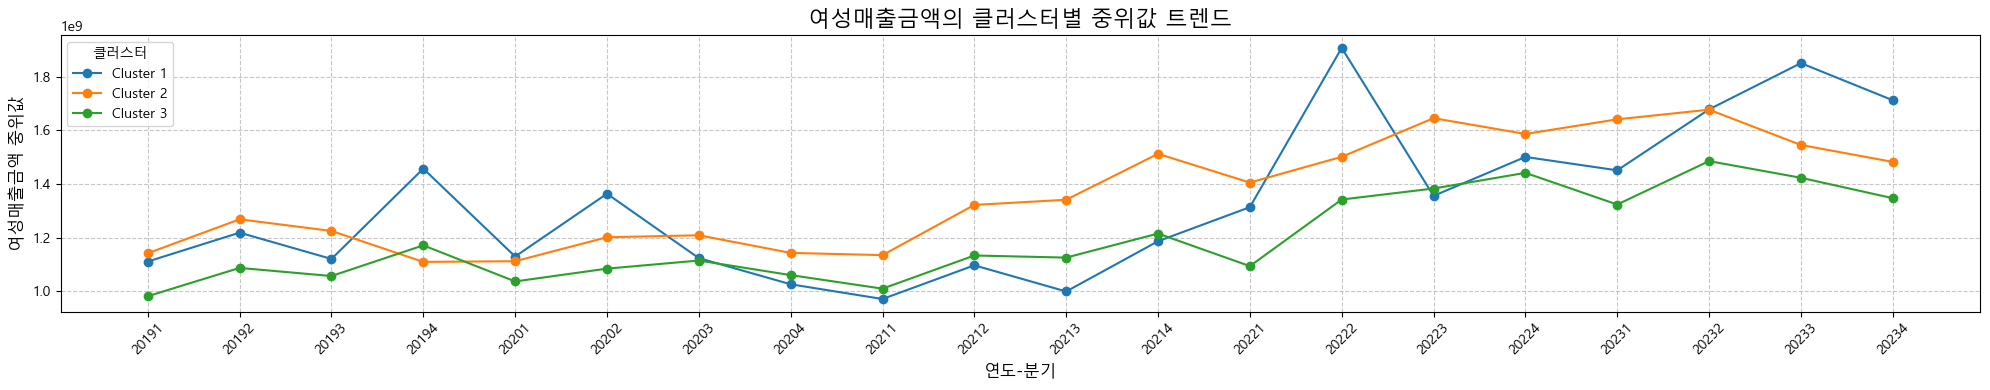

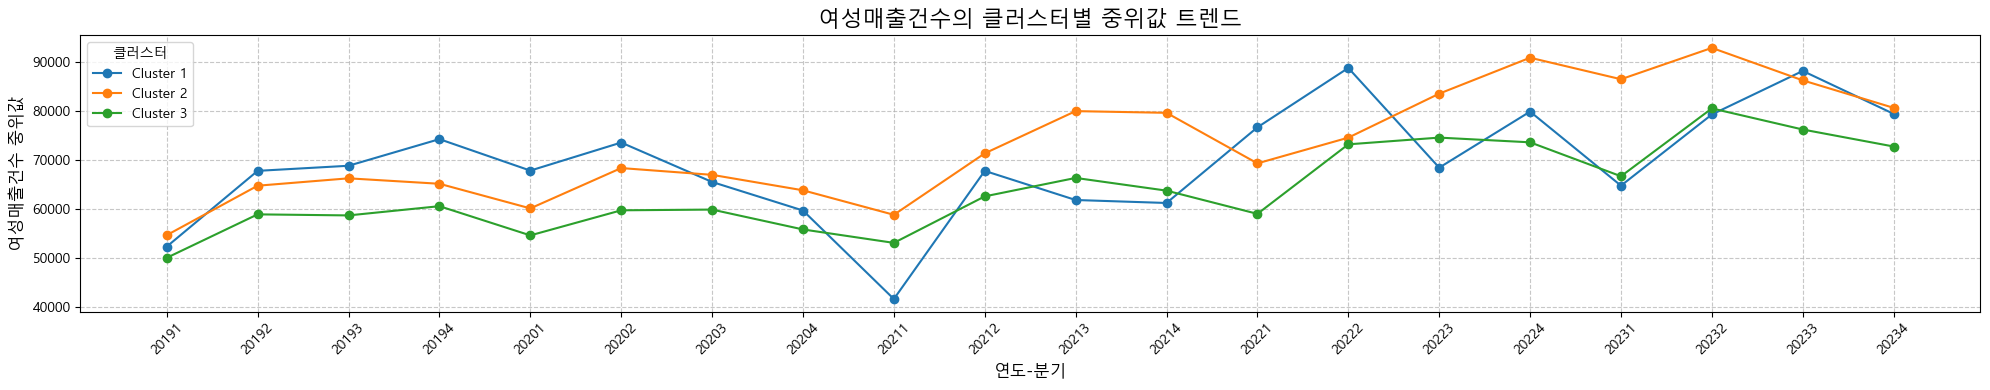

cluster  year quarter period        0        1        2        3
0        2019       1  20191  14873.0  52233.0  54572.0  49949.5
1        2019       2  20192  16781.0  67711.0  64677.0  58822.0
2        2019       3  20193  17702.0  68751.0  66185.0  58608.0
3        2019       4  20194  16842.0  74190.0  65073.0  60494.0
4        2020       1  20201  16409.0  67763.5  60043.0  54527.0
5        2020       2  20202  13818.0  73494.0  68281.0  59651.0
6        2020       3  20203  13650.0  65441.0  66897.0  59800.0
7        2020       4  20204   9192.0  59608.0  63738.0  55742.0
8        2021       1  20211   8444.0  41530.0  58734.0  52998.0
9        2021       2  20212  41141.0  67704.5  71286.0  62498.0
10       2021       3  20213  38486.0  61756.0  79914.5  66266.0
11       2021       4  20214  32194.0  61148.0  79564.5  63669.5
12       2022       1  20221  34253.0  76602.0  69239.0  58925.0
13       2022       2  20222  34264.0  88732.0  74496.0  73129.5
14       2022       3  20223  31982.0  68362.5  83479.0  74502.0
15       2022       4  20224  29440.0  79815.0  90822.0  73540.0
16       2023       1  20231  28169.0  64686.0  86425.5  66606.0
17       2023       2  20232  29288.0  79228.5  92830.0  80468.0
18       2023       3  20233  27043.0  88123.0  86196.0  76156.0
19       2023       4  20234  17510.0  79350.0  80579.0  72683.0

In [19]:
help_me_median(df_final, '남성매출금액')
help_me_median(df_final, '남성매출건수')

help_me_median(df_final, '여성매출금액')
help_me_median(df_final, '여성매출건수')